# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Discrete)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic Real-Time Bidding (RTB) dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# import SCOPE-RL modules
import scope_rl
from rtbgym import RTBEnv, CustomizedRTBEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.policy import DiscreteEpsilonGreedyHead as EpsilonGreedyHead
from scope_rl.policy import DiscreteSoftmaxHead as SoftmaxHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler
from scope_rl.utils import MinMaxScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [4]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# version
print(scope_rl.__version__)

0.0.0


In [6]:
# set random state
random_state = 12345

In [7]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the RTB environment works.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe some feedback from the environment at each timestep, which includes the following.
  - timestep
  - remaining budget
  - impression level features (budget consumption rate, cost per mille of impressions, auction winning rate, reward) at the previous timestep
  - adjust rate (RL agent's decision making) at the previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb).

In [8]:
# standardized environment for discrete action
env = gym.make("RTBEnv-discrete-v0")

In [9]:
# for api compatibility to d3rlpy
from scope_rl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: RTB environment for RL defined in the previous section.
- `action_meaning`: Dictionary which maps discrete action index into specific actions.
- `state_keys`: Name of the state variable at each dimension.
- `max_episode_steps`: Maximum number of timesteps in an episode.
- `info_keys`: Dictionary containing of key and the type of info components.

For more about the data collection and visualization, please refer to [examples/quickstart/rtb/rtb_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_data_collection.ipynb).

In [10]:
# behavior policy
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [ ]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [11]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

In [12]:
behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [13]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [14]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state + 1,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
with open("logs/train_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [16]:
with open("logs/train_dataset_discrete_ddqn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rtb/rtb_synthetic_discrete_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_discrete_basic.ipynb).

In [17]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL as CQL
# transform offline dataset for d3rlpy
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
    episode_terminals=train_logged_dataset["done"],
    discrete_action=True,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [18]:
# Use Conservative Q-Learning (CQL) policy
# base policy 1: hidden_units = [30, 30]
cql_b1 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [ ]:
cql_b1.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [20]:
# save model
cql_b1.save_model("d3rlpy_logs/cql_discrete_b1.pt")

In [21]:
# reload model
cql_b1.build_with_env(env)
cql_b1.load_model("d3rlpy_logs/cql_discrete_b1.pt")

2023-06-01 18:16:07 [warning  ] Parameters will be reinitialized.


In [22]:
# Use Conservative Q-Learning (CQL) policy
# base policy 2: hidden_units = [100]
cql_b2 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [ ]:
cql_b2.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [24]:
# save model
cql_b2.save_model("d3rlpy_logs/cql_discrete_b2.pt")

In [25]:
# reload model
cql_b2.build_with_env(env)
cql_b2.load_model("d3rlpy_logs/cql_discrete_b2.pt")

2023-06-01 18:16:19 [warning  ] Parameters will be reinitialized.


In [26]:
# Use Conservative Q-Learning (CQL) policy
# base policy 3: hidden_units = [50, 10]
cql_b3 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [ ]:
cql_b3.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

In [28]:
# save model
cql_b3.save_model("d3rlpy_logs/cql_discrete_b3.pt")

In [29]:
# reload model
cql_b3.build_with_env(env)
cql_b3.load_model("d3rlpy_logs/cql_discrete_b3.pt")

2023-06-01 18:16:32 [warning  ] Parameters will be reinitialized.


## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$


In [30]:
# import ope modules from SCOPE-RL
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as BasicOPE
from scope_rl.ope import DiscreteDirectMethod as DM
from scope_rl.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from scope_rl.ope import DiscretePerDecisionImportanceSampling as PDIS
from scope_rl.ope import DiscreteDoublyRobust as DR
from scope_rl.ope import DiscreteSelfNormalizedTIS as SNTIS
from scope_rl.ope import DiscreteSelfNormalizedPDIS as SNPDIS
from scope_rl.ope import DiscreteSelfNormalizedDR as SNDR

In [31]:
# define evaluation policies (epsilon-greedy and softmax)
cql_b1_00 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon00", epsilon=0.0, random_state=random_state)
cql_b1_03 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon03", epsilon=0.3, random_state=random_state)
cql_b1_07 = EpsilonGreedyHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_epsilon07", epsilon=0.7, random_state=random_state)
cql_b1_soft = SoftmaxHead(base_policy=cql_b1, n_actions=env.action_space.n, name="cql_b1_softmax", random_state=random_state)

cql_b2_00 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon00", epsilon=0.0, random_state=random_state)
cql_b2_03 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon03", epsilon=0.3, random_state=random_state)
cql_b2_07 = EpsilonGreedyHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_epsilon07", epsilon=0.7, random_state=random_state)
cql_b2_soft = SoftmaxHead(base_policy=cql_b2, n_actions=env.action_space.n, name="cql_b2_softmax", random_state=random_state)

cql_b3_00 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon00", epsilon=0.0, random_state=random_state)
cql_b3_03 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon03", epsilon=0.3, random_state=random_state)
cql_b3_07 = EpsilonGreedyHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_epsilon07", epsilon=0.7, random_state=random_state)
cql_b3_soft = SoftmaxHead(base_policy=cql_b3, n_actions=env.action_space.n, name="cql_b3_softmax", random_state=random_state)

evaluation_policies = [
    cql_b1_00, cql_b1_03, cql_b1_07, cql_b1_soft, 
    cql_b2_00, cql_b2_03, cql_b2_07, cql_b2_soft, 
    cql_b3_00, cql_b3_03, cql_b3_07, cql_b3_soft,
]

In [32]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
)

In [ ]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [34]:
with open("logs/ope_input_dict_discrete_advanced.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [35]:
with open("logs/ope_input_dict_discrete_advanced.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [36]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [37]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict

{'cql_b1_epsilon00':            policy_value  relative_policy_value
 on_policy     14.520000               1.000000
 dm             1.896489               0.130612
 tis            1.113988               0.076721
 pdis          13.476283               0.928119
 dr            14.238137               0.980588
 sntis         14.650794               1.009008
 snpdis        14.062081               0.968463
 sndr          14.016474               0.965322,
 'cql_b1_epsilon03':            policy_value  relative_policy_value
 on_policy     14.610000               1.000000
 dm             1.841312               0.126031
 tis            8.096685               0.554188
 pdis          14.305693               0.979171
 dr            14.627609               1.001205
 sntis         13.992896               0.957762
 snpdis        14.245268               0.975035
 sndr          14.211735               0.972740,
 'cql_b1_epsilon07':            policy_value  relative_policy_value
 on_policy     13.950000  

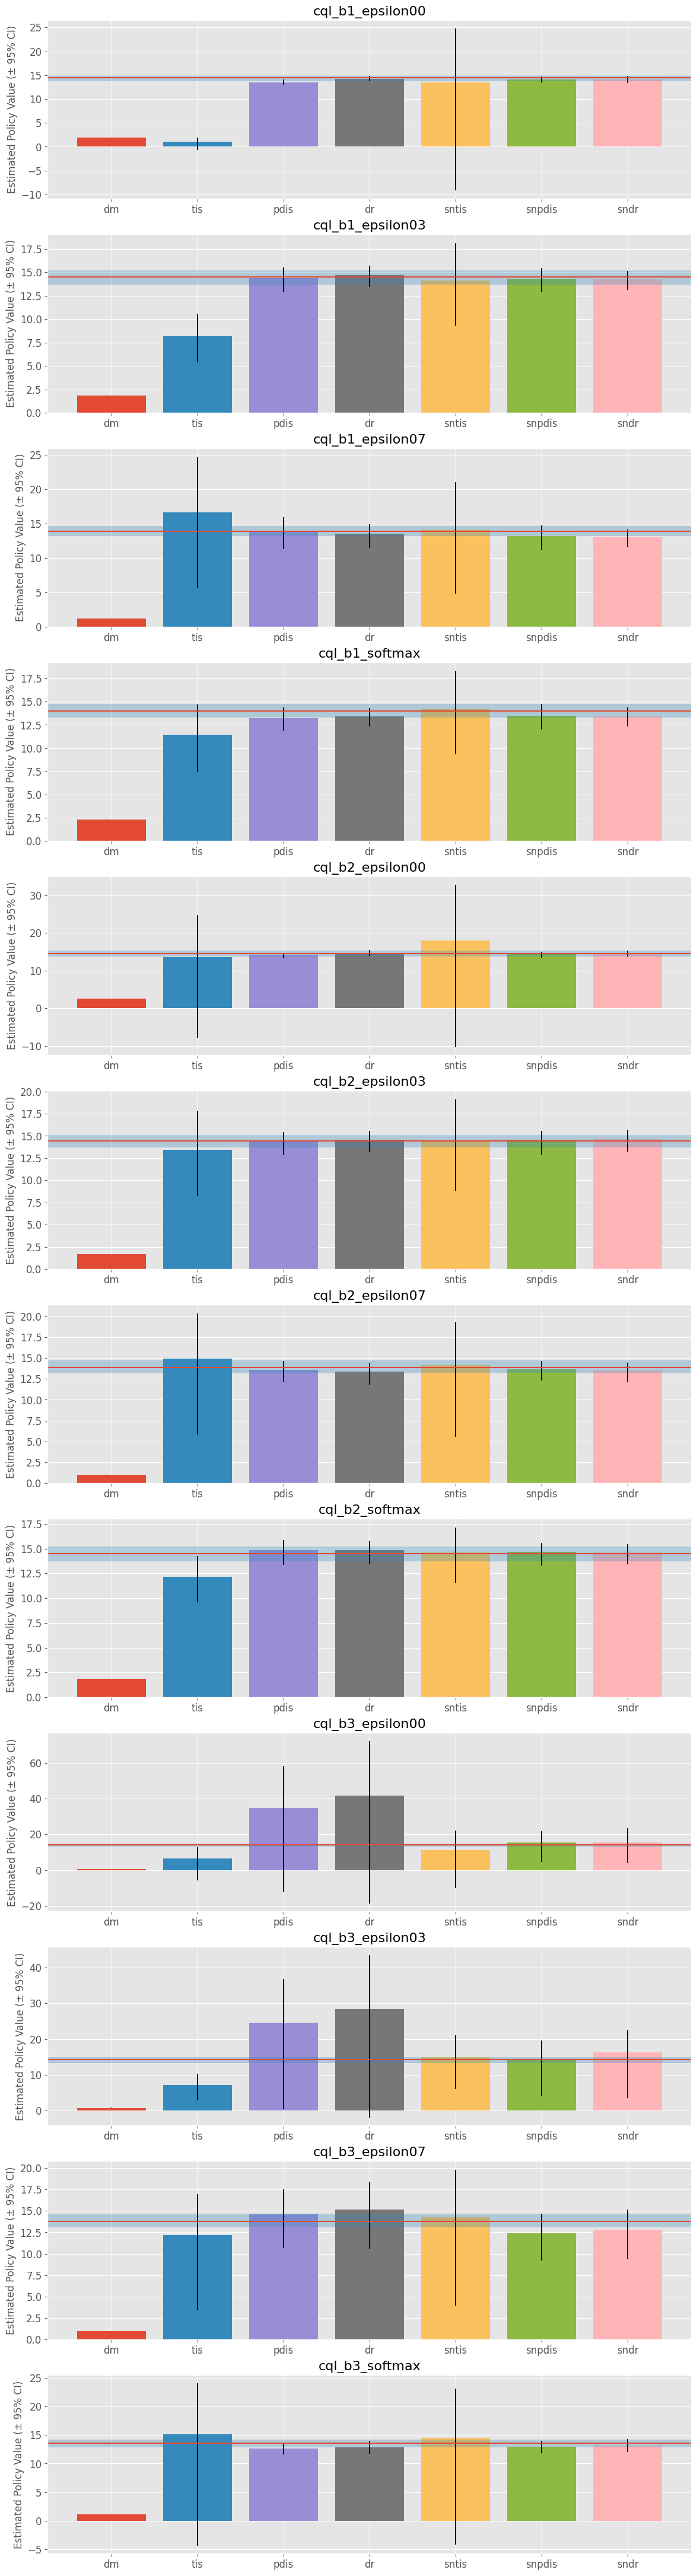

In [38]:
# visualize and compare the result
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

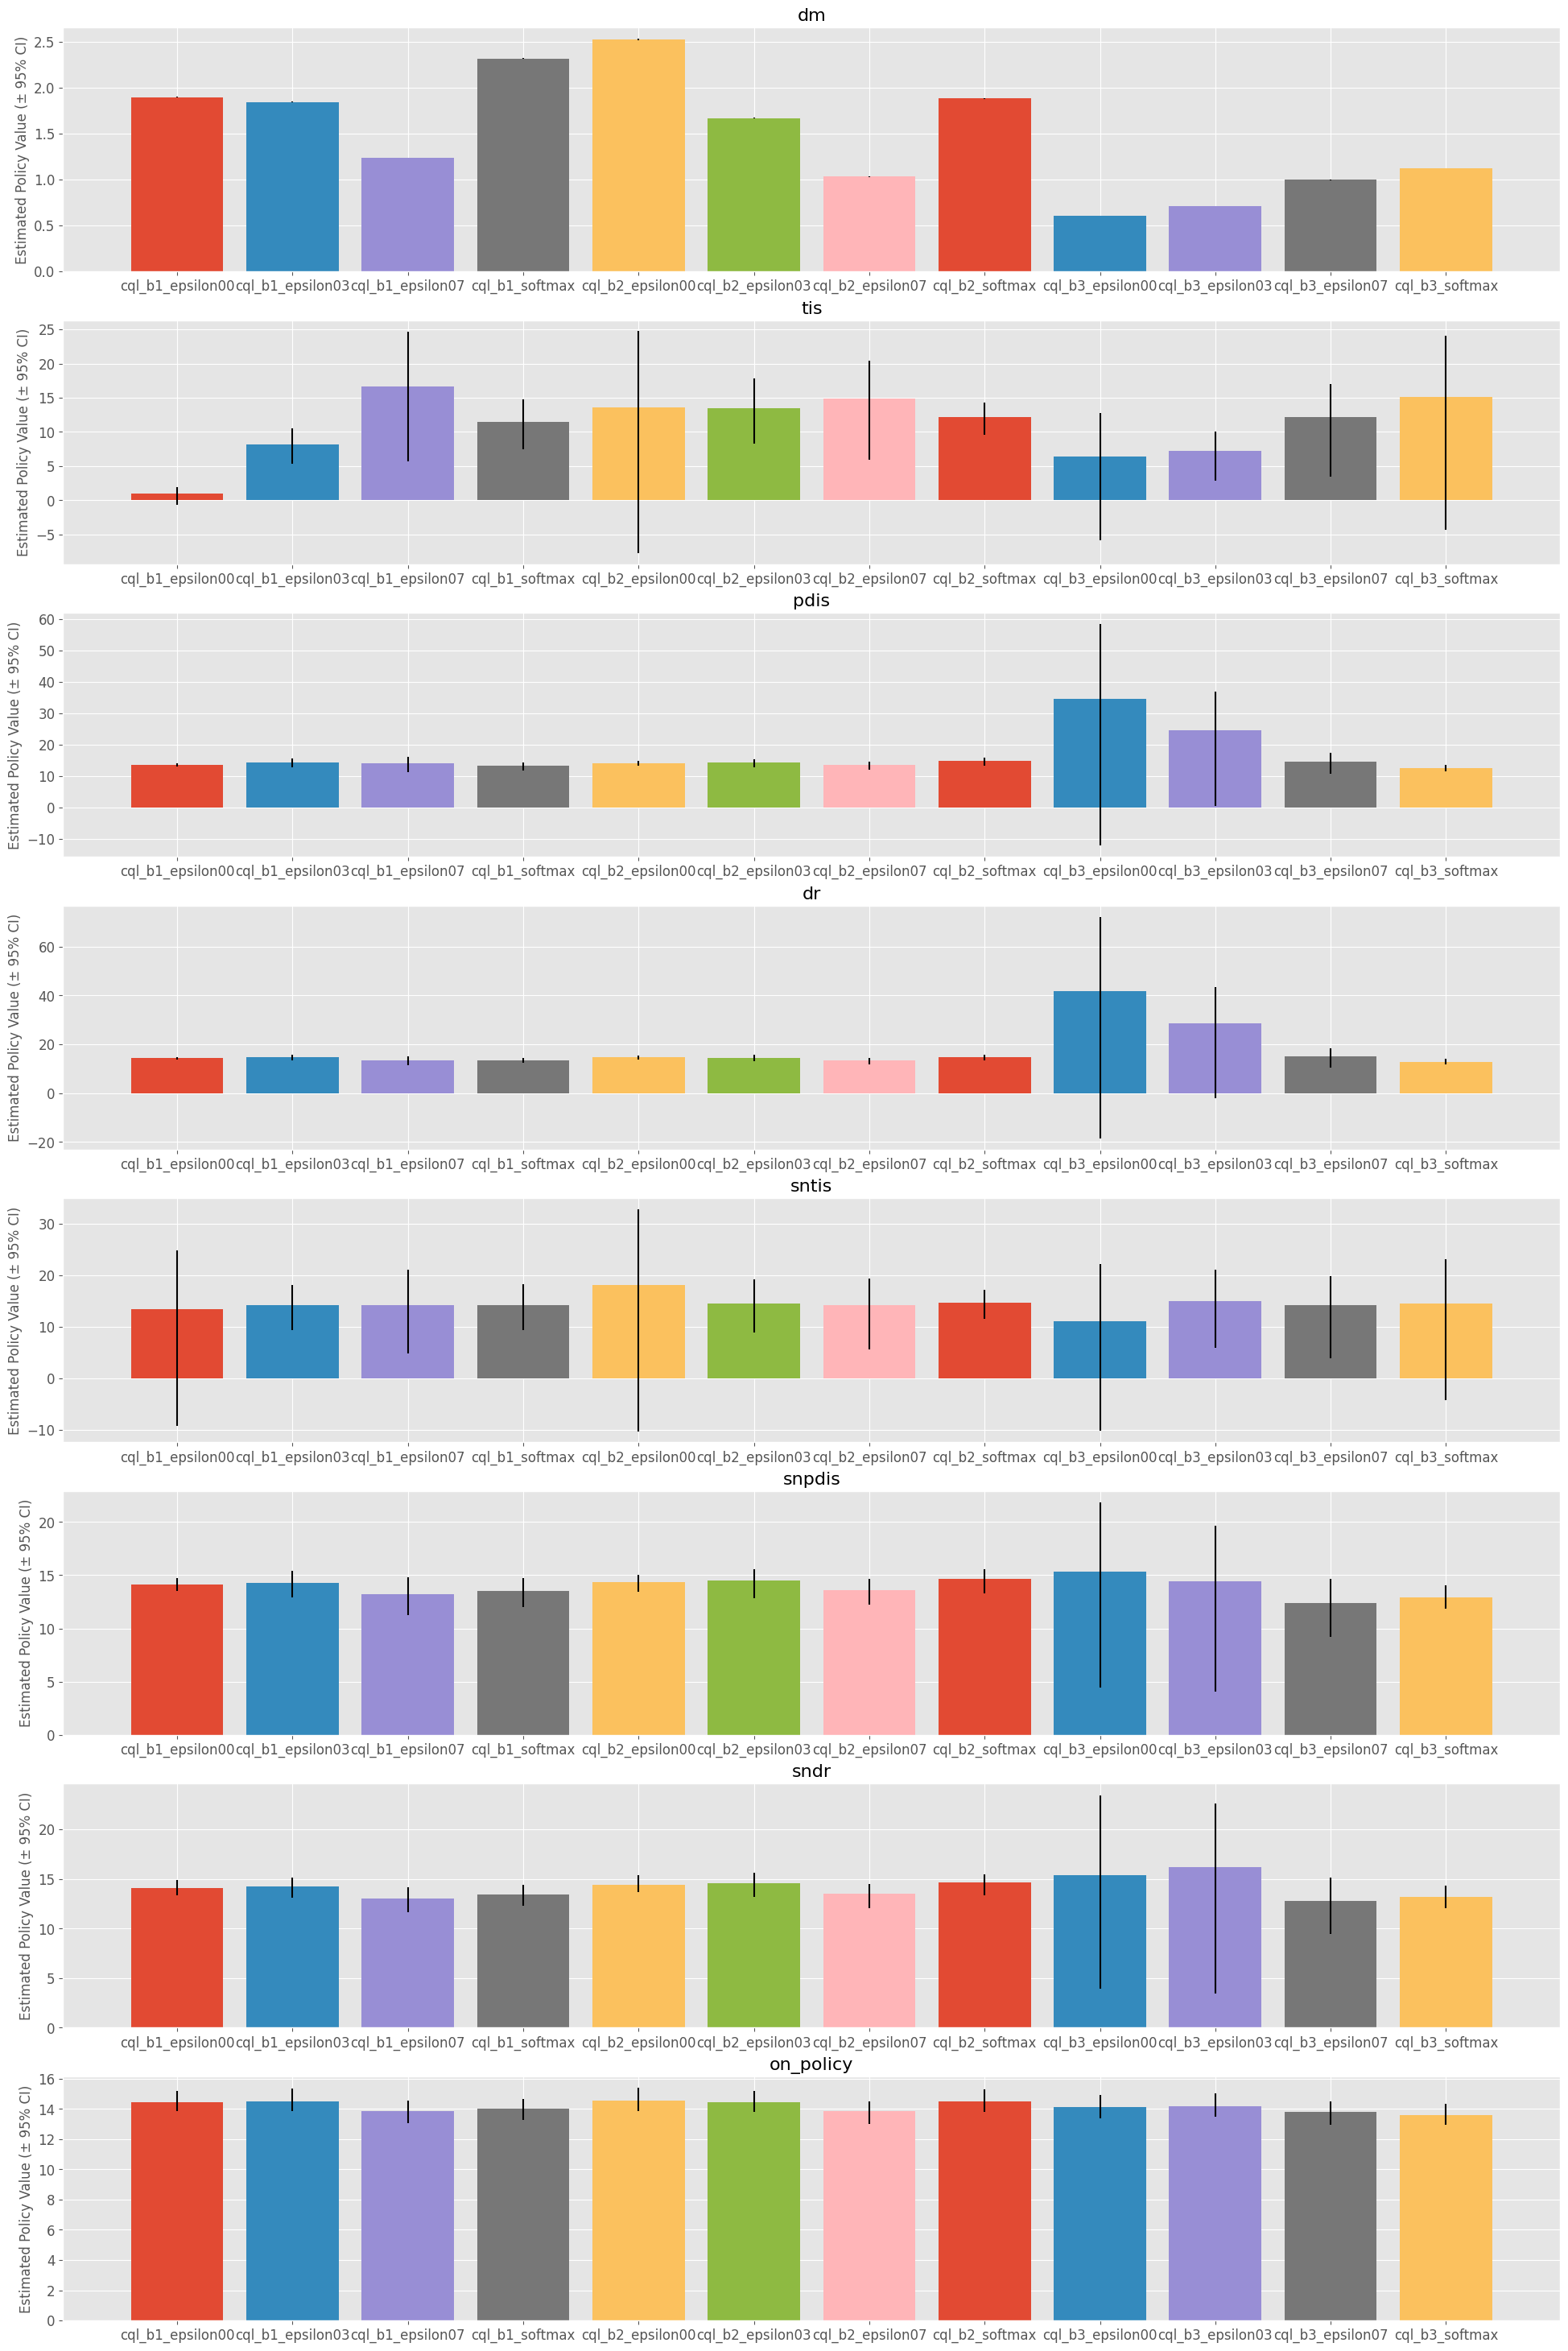

In [39]:
# we can also compare the policy value of candidate OPE estimators estimated by a single OPE estimator
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, hue="policy", sharey=False)
# relative policy value to the behavior policy
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, hue="policy", sharey=False)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [40]:
from scope_rl.ope import CumulativeDistributionOPE
from scope_rl.ope import DiscreteCumulativeDistributionDM as CD_DM
from scope_rl.ope import DiscreteCumulativeDistributionTIS as CD_IS
from scope_rl.ope import DiscreteCumulativeDistributionTDR as CD_DR
from scope_rl.ope import DiscreteCumulativeDistributionSNTIS as CD_SNIS
from scope_rl.ope import DiscreteCumulativeDistributionSNTDR as CD_SNDR

In [41]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

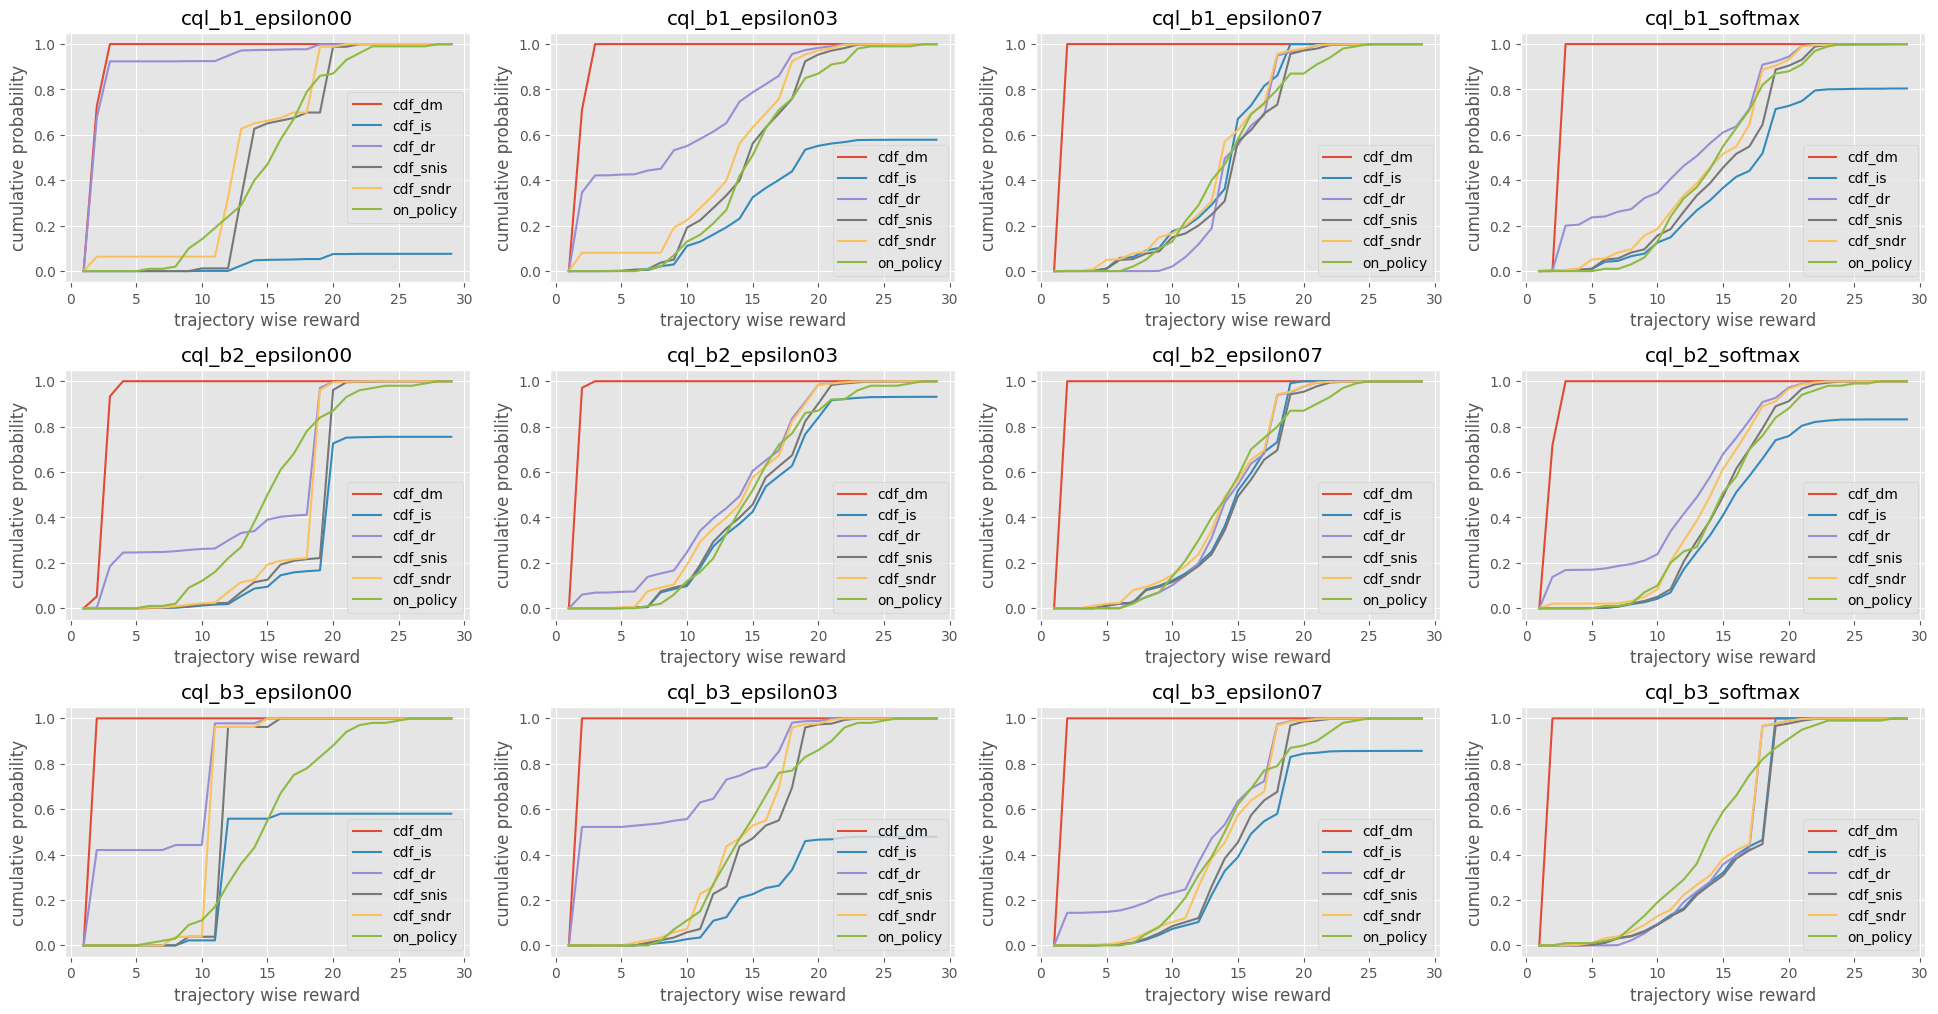

In [42]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function(input_dict, n_cols=4)

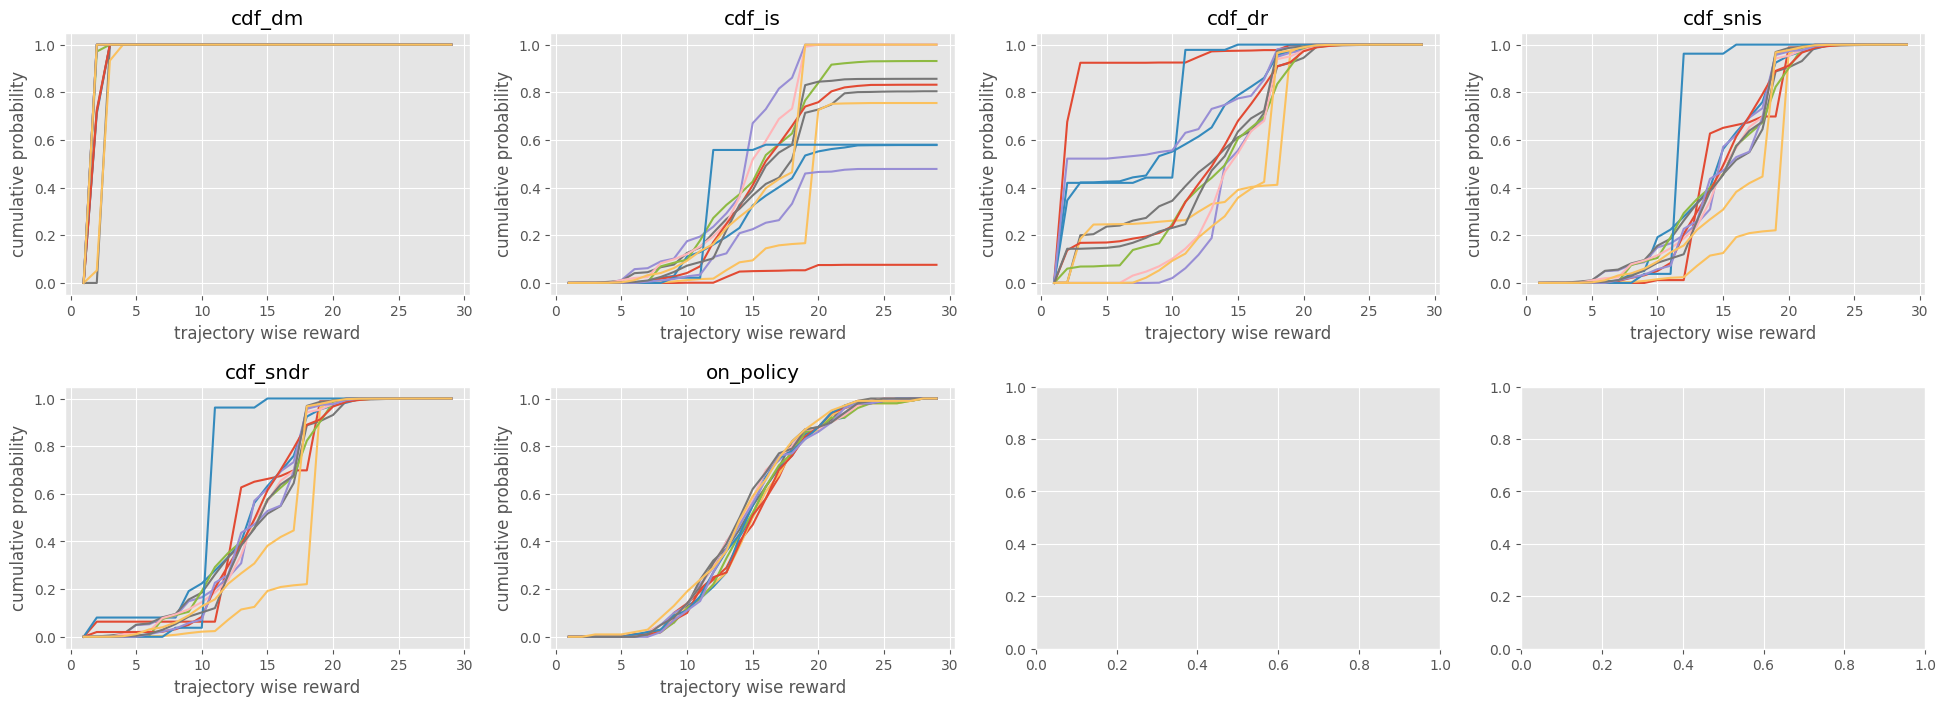

In [43]:
# cumulative distribution function comparison by each OPE estimator
# legend (evaluation policy name) is omitted here
cd_ope.visualize_cumulative_distribution_function(
    input_dict, 
    hue="policy",
    n_cols=4,
    legend=False,
)

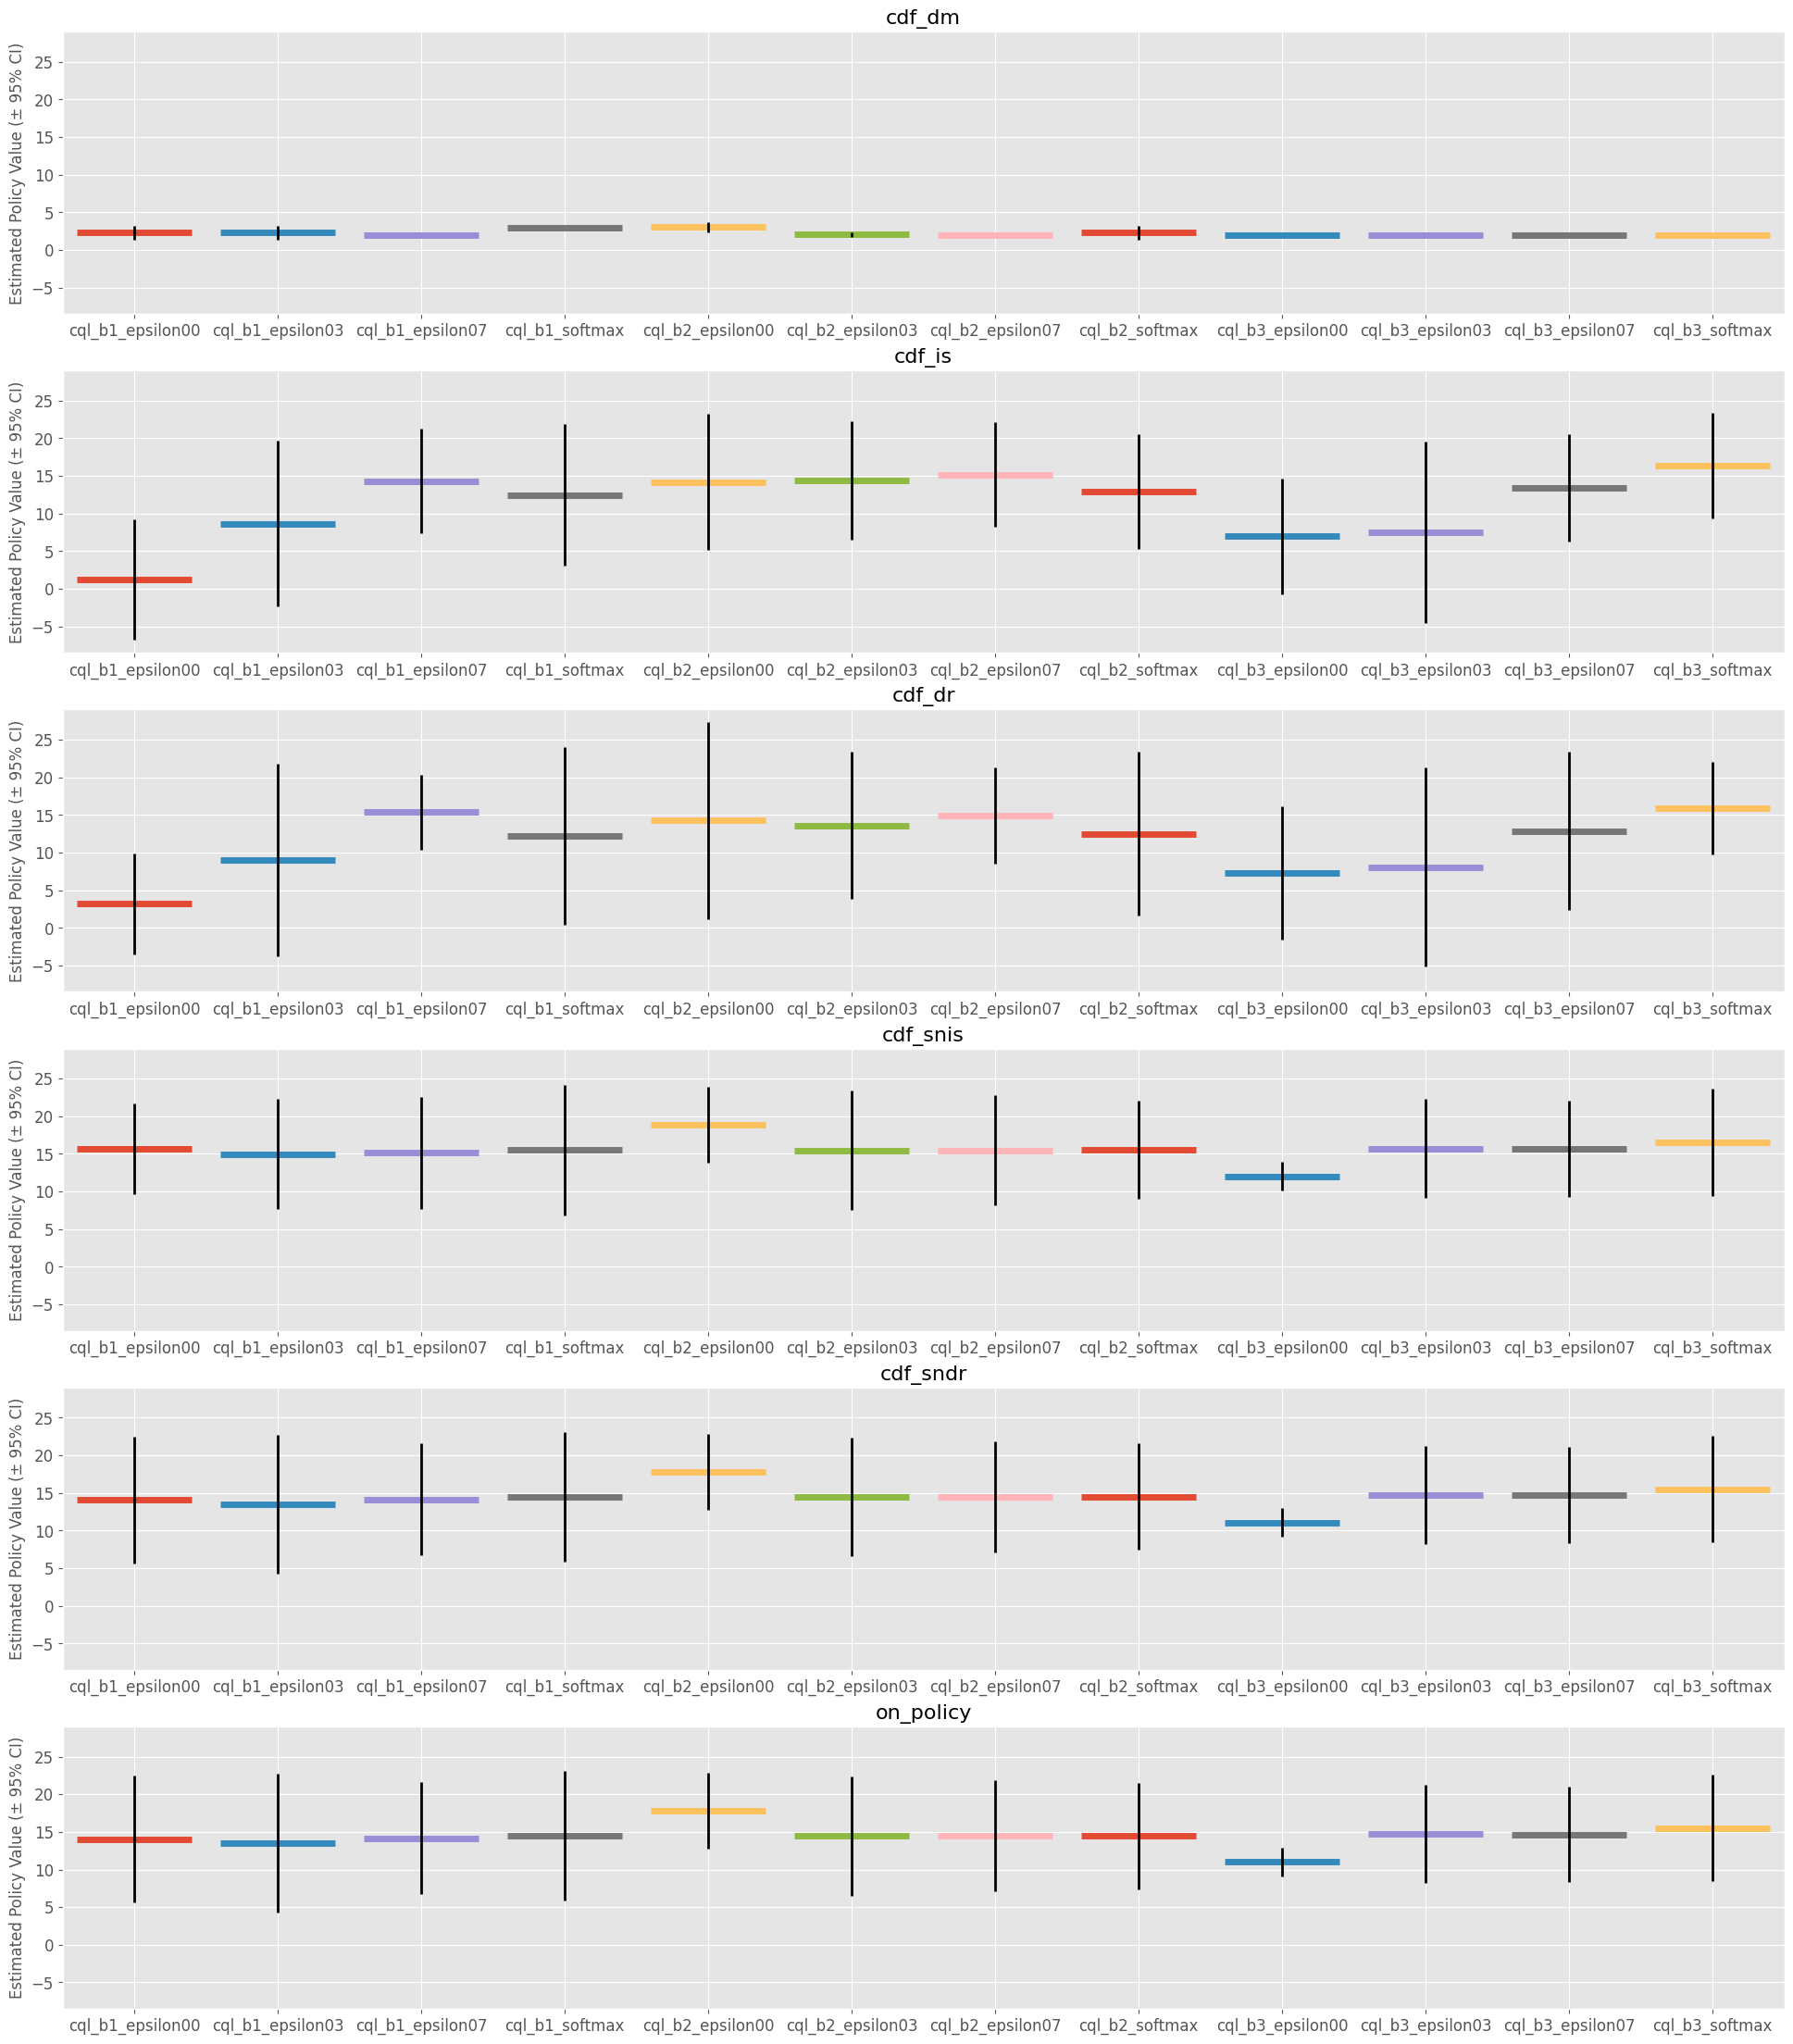

In [44]:
# policy value calculated from cumulative distribution function
mean_dict = cd_ope.estimate_mean(input_dict)
variance_dict = cd_ope.estimate_variance(input_dict)

# visualize the policy value and its confidence intervals based on the mean and variance
# cd_ope.visualize_policy_value(input_dict, sharey=True)
# comparison among candidate policies by an OPE estimator
cd_ope.visualize_policy_value(input_dict, hue="policy", sharey=True)

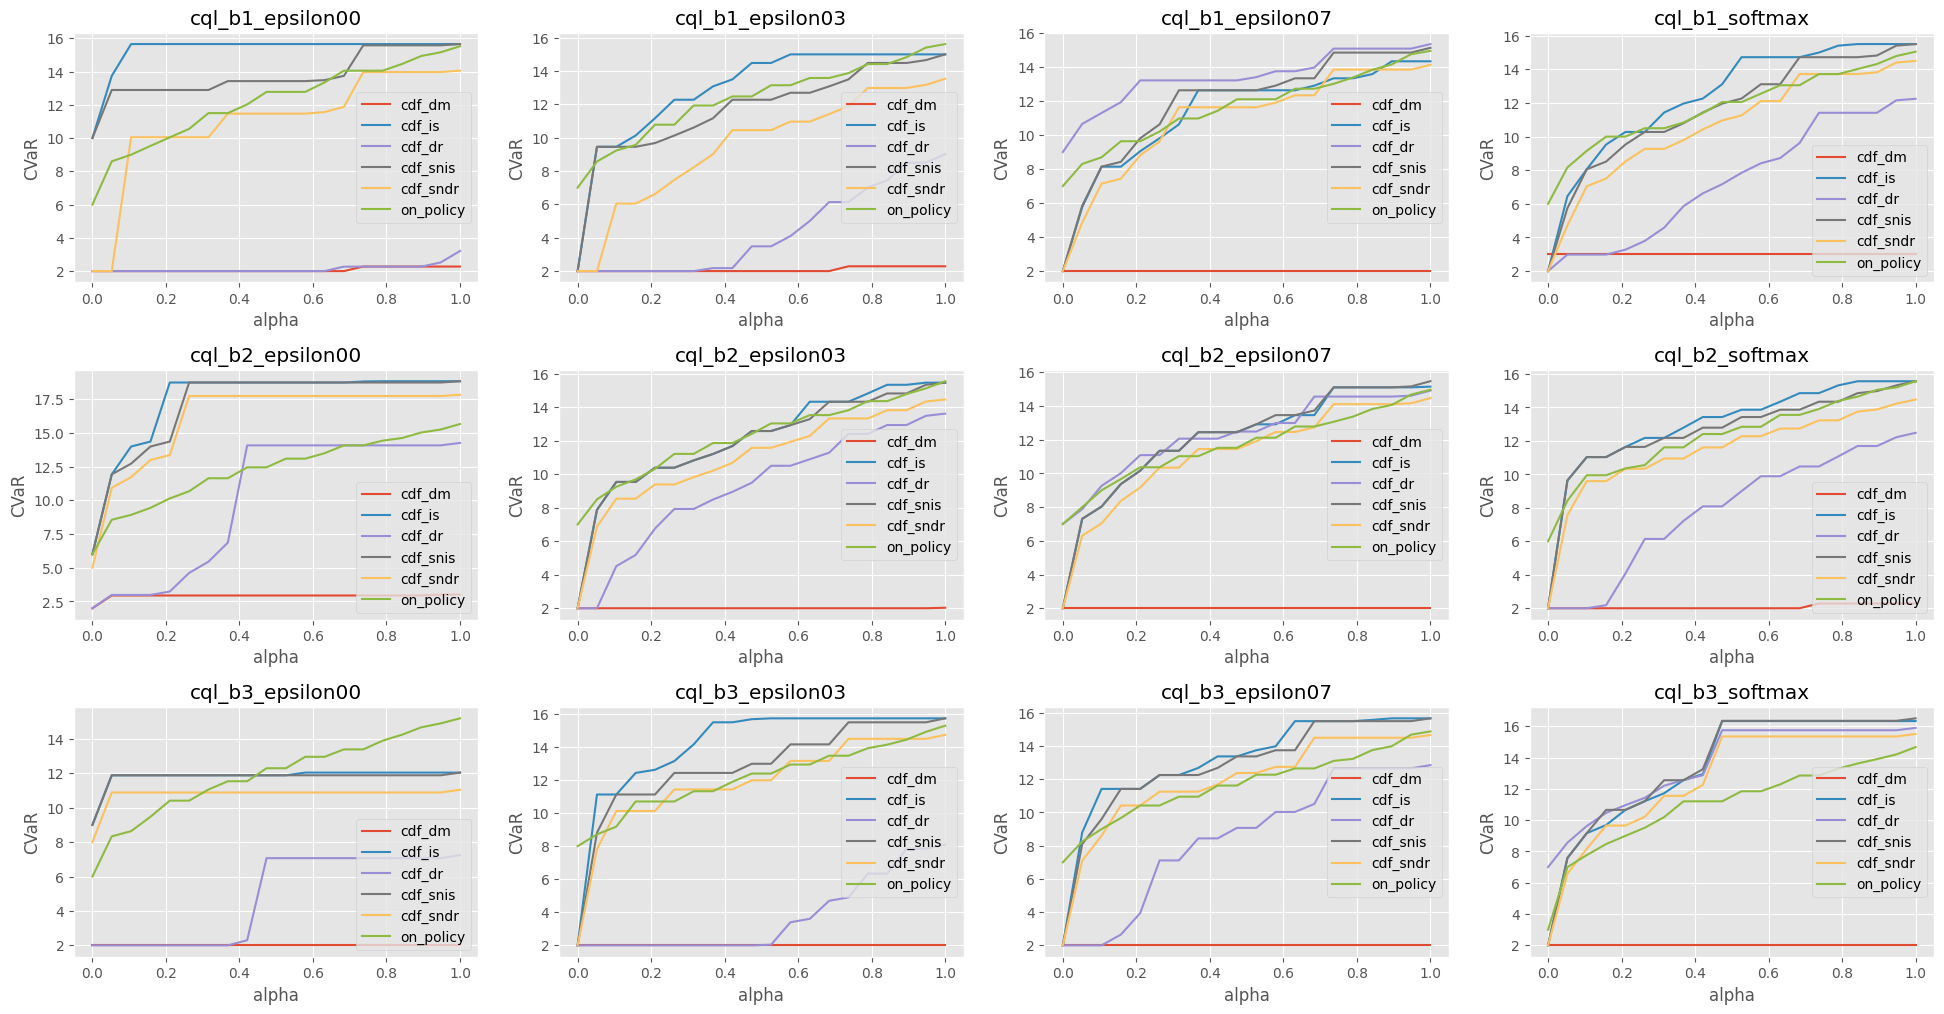

In [45]:
# conditional value at risk
cvar_dict = cd_ope.estimate_conditional_value_at_risk(input_dict, alphas=0.3)
# visualize conditional value at risk
cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=4, sharey=True)
# comparison among candidate policies by an OPE estimator
# cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=4, sharey=True)

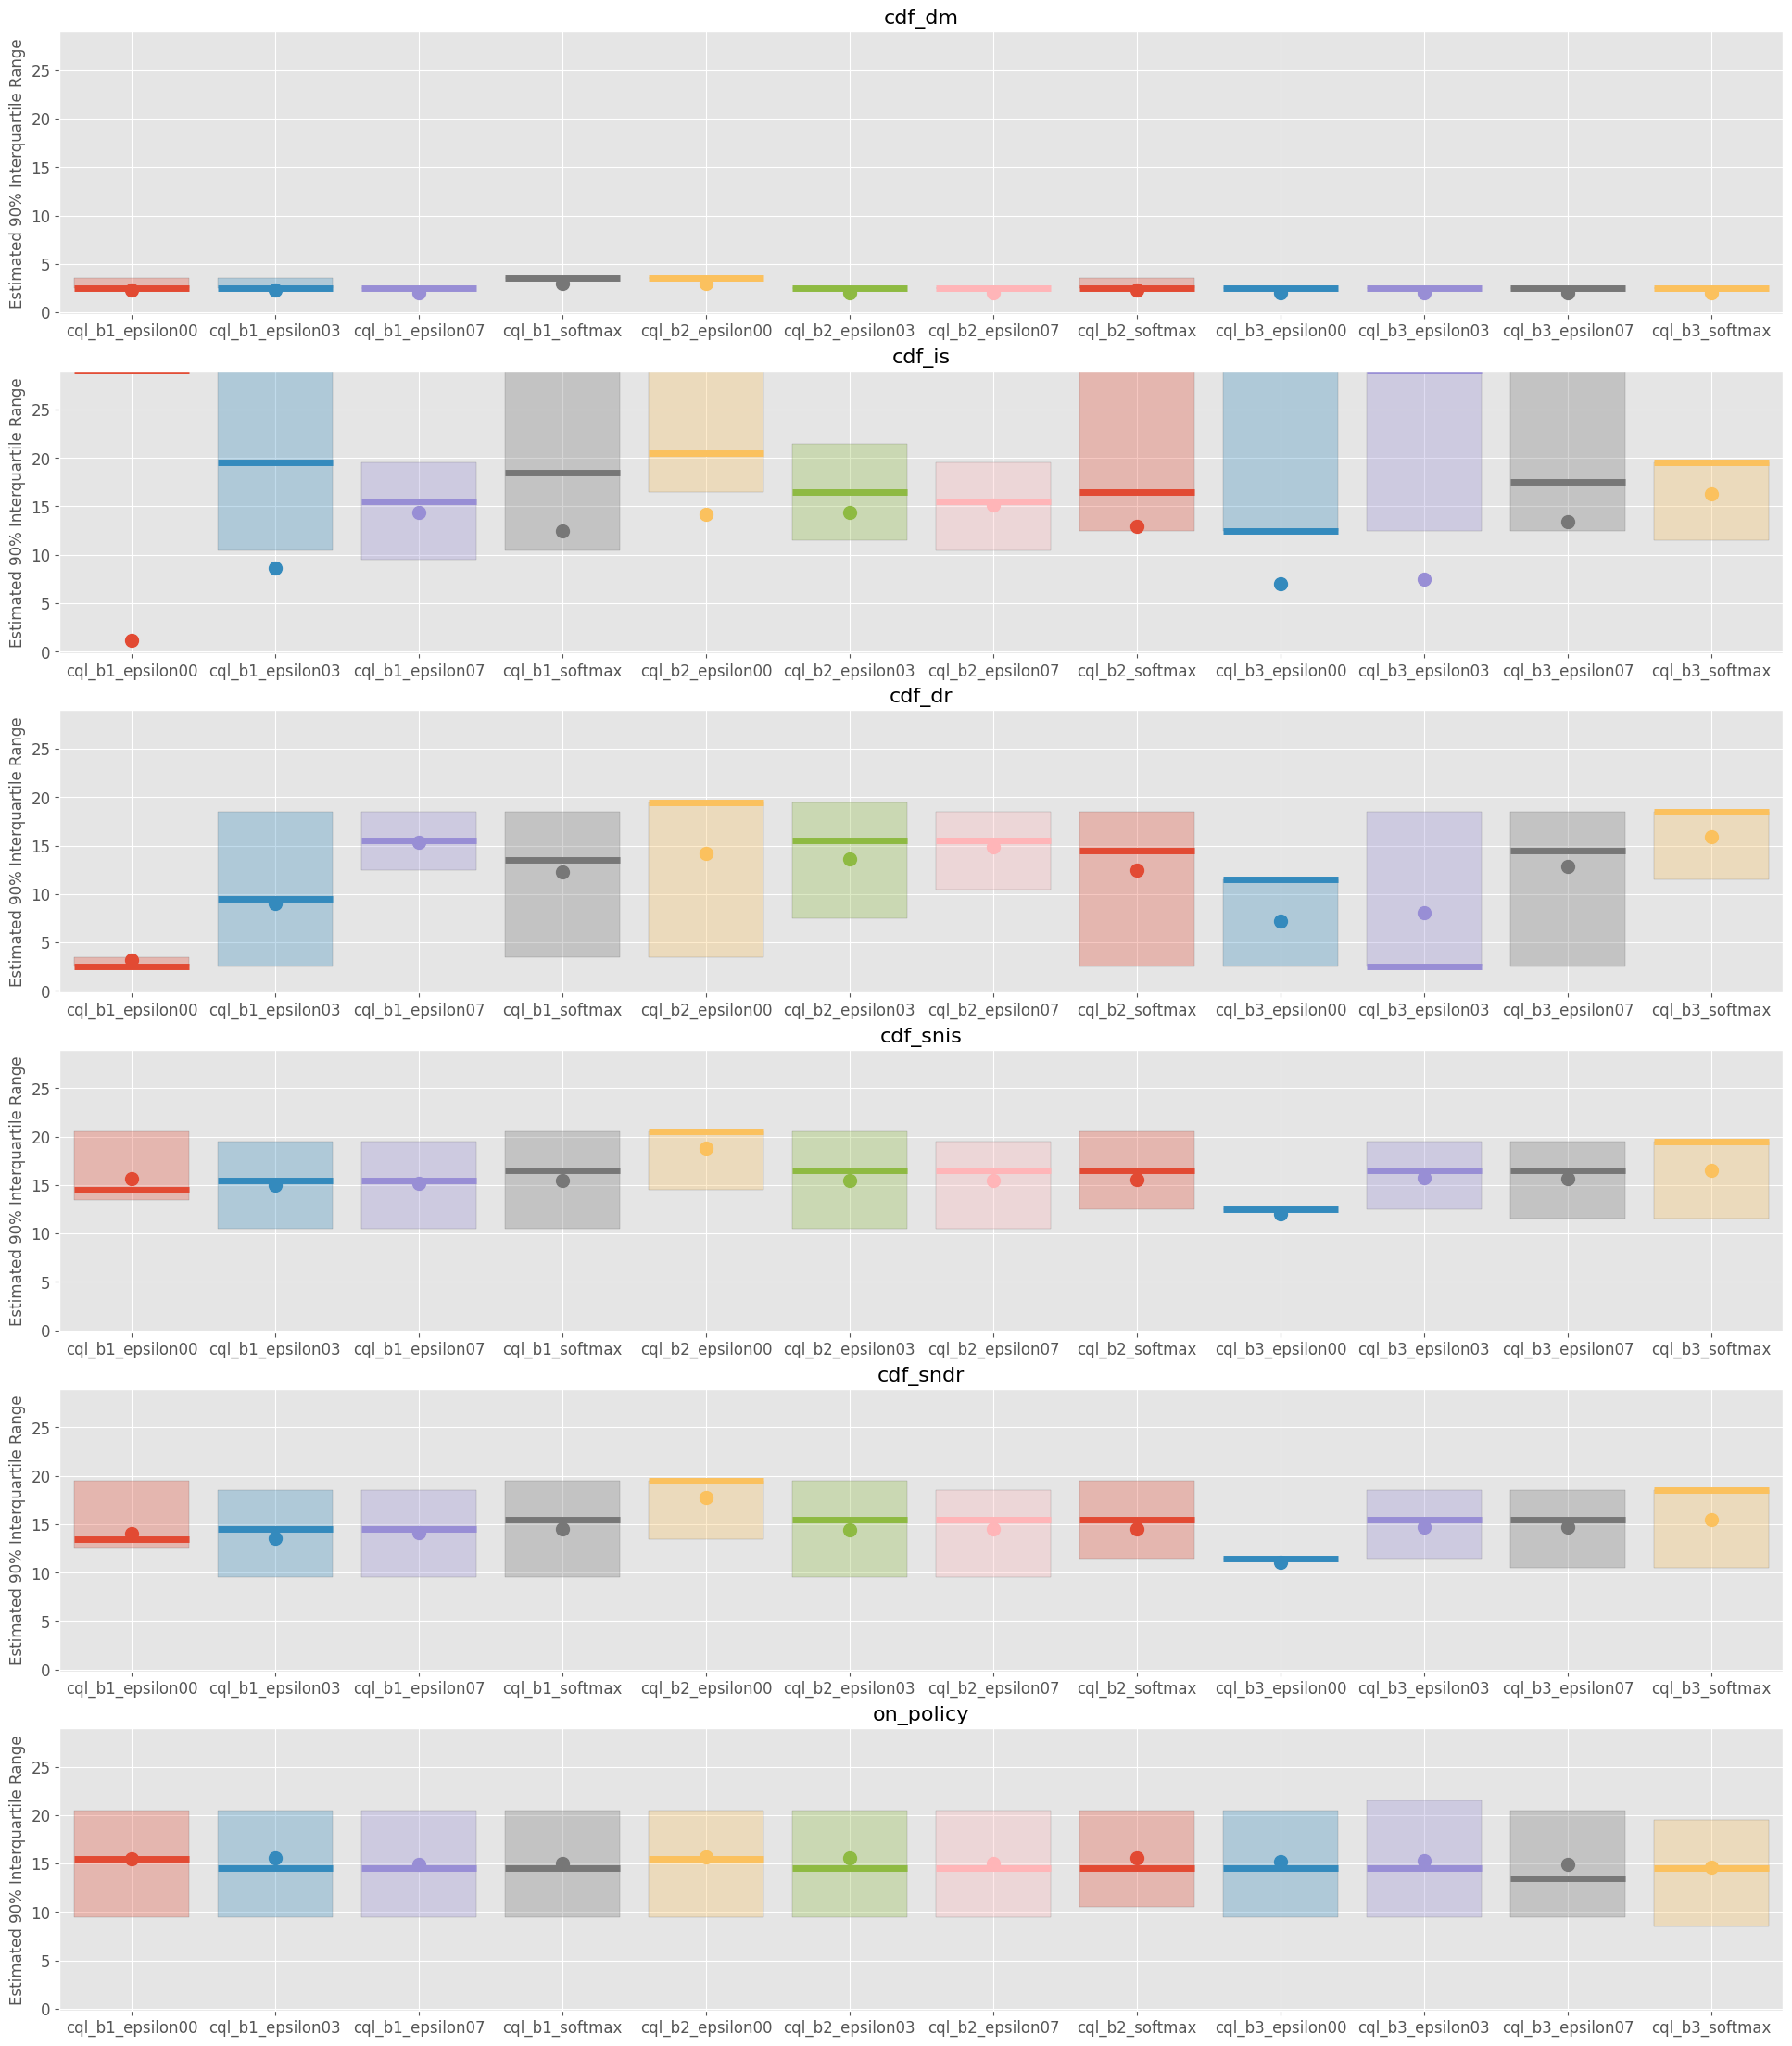

In [46]:
# interquartile range
interquartile_range_dict = cd_ope.estimate_interquartile_range(input_dict, alpha=0.10)
# visualize interquartile range
# cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, sharey=True)
# comparison among candidate policies by an OPE estimator
cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, hue="policy", sharey=True)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [47]:
from scope_rl.ope import OffPolicySelection

In [49]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [50]:
ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)

ranking  policy_value  relative_policy_value   variance  \
0   cql_b2_epsilon00         14.65               1.020614  17.017677   
1   cql_b1_epsilon03         14.61               1.017828  16.644343   
2     cql_b2_softmax         14.57               1.015041  16.166768   
3   cql_b2_epsilon03         14.55               1.013648  17.381313   
4   cql_b1_epsilon00         14.52               1.011558  16.797576   
5   cql_b3_epsilon03         14.29               0.995534  16.248384   
6   cql_b3_epsilon00         14.19               0.988568  16.256465   
7     cql_b1_softmax         14.05               0.978814  16.088384   
8   cql_b2_epsilon07         13.97               0.973241  17.423333   
9   cql_b1_epsilon07         13.95               0.971848  17.300505   
10  cql_b3_epsilon07         13.88               0.966971  16.934949   
11    cql_b3_softmax         13.67               0.952341  18.627374   

   ranking_by_lower_quartile  lower_quartile  \
0           cql_b1_epsilon00            8.00   
1           cql_b1_epsilon03            8.00   
2           cql_b1_epsilon07            8.00   
3             cql_b1_softmax            8.00   
4           cql_b2_epsilon00            8.00   
5           cql_b2_epsilon03            8.00   
6           cql_b2_epsilon07            8.00   
7             cql_b2_softmax            8.00   
8           cql_b3_epsilon00            7.95   
9           cql_b3_epsilon03            7.95   
10          cql_b3_epsilon07            7.95   
11            cql_b3_softmax            7.00   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                      cql_b3_epsilon03                        7.6  
1                      cql_b2_epsilon03                        7.4  
2                      cql_b1_epsilon03                        7.4  
3                        cql_b2_softmax                        7.2  
4                      cql_b2_epsilon00                        7.2  
5                      cql_b1_epsilon00                        7.2  
6                        cql_b1_softmax                        7.0  
7                      cql_b3_epsilon07                        6.8  
8                      cql_b3_epsilon00                        6.8  
9                      cql_b2_epsilon07                        6.6  
10                     cql_b1_epsilon07                        6.6  
11                       cql_b3_softmax                        5.4

In [51]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [52]:
ranking_df

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0   cql_b2_epsilon00                2.522469                         0.175732   
 1     cql_b1_softmax                2.316923                         0.161412   
 2   cql_b1_epsilon00                1.896489                         0.132122   
 3     cql_b2_softmax                1.882151                         0.131123   
 4   cql_b1_epsilon03                1.841312                         0.128278   
 5   cql_b2_epsilon03                1.667015                         0.116135   
 6   cql_b1_epsilon07                1.232999                         0.085899   
 7     cql_b3_softmax                1.122184                         0.078179   
 8   cql_b2_epsilon07                1.031107                         0.071834   
 9   cql_b3_epsilon07                0.995456                         0.069350   
 10  cql_b3_epsilon03                0.708454                         0.049355   
 11  cql_b

In [53]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm          162.978189          0.545455  0.066612      0.00   
1       tis           30.490502         -0.412587  0.182564      0.70   
2      pdis           37.104381          0.377622  0.226206      0.46   
3        dr           66.673548          0.356643  0.255138      0.46   
4     sntis            2.089707         -0.048951  0.879919      0.00   
5    snpdis            0.489457          0.776224  0.002993      0.46   
6      sndr            0.564616          0.664336  0.018453      0.36   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0  
5                0.0                 0.0  
6                0.0                 0.0

In [54]:
ranking_df, metric_df = ops.select_by_policy_value_via_cumulative_distribution_ope(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [55]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0    cdf_dm          144.173436          0.545455  0.066612      0.00   
1    cdf_is           27.066381         -0.377622  0.226206      0.98   
2    cdf_dr           21.951750         -0.405594  0.190836      0.98   
3  cdf_snis            3.697773         -0.048951  0.879919      0.00   
4  cdf_sndr            2.172356         -0.146853  0.648796      0.00   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0

In [56]:
ranking_df, metric_df = ops.select_by_policy_value_lower_bound(
    input_dict=input_dict,
    cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    return_metrics=True,
    return_by_dataframe=True,
    random_state=12345,
)

In [57]:
metric_df

ci estimator  mean_squared_error  rank_correlation    pvalue  \
0   bootstrap        dm                 NaN          0.545455  0.066612   
1   bootstrap       tis                 NaN         -0.174825  0.586824   
2   bootstrap      pdis                 NaN          0.832168  0.000785   
3   bootstrap        dr                 NaN          0.811189  0.001363   
4   bootstrap     sntis                 NaN          0.202797  0.527302   
5   bootstrap    snpdis                 NaN          0.671329  0.016831   
6   bootstrap      sndr                 NaN          0.664336  0.018453   
7   bernstein        dm                 NaN          0.545455  0.066612   
8   bernstein       tis                 NaN          0.426573  0.166700   
9   bernstein      pdis                 NaN          0.349650  0.265239   
10  bernstein        dr                 NaN          0.370629  0.235621   
11  bernstein     sntis                 NaN          0.272727  0.391097   
12  bernstein    snpdis                 NaN          0.349650  0.265239   
13  bernstein      sndr                 NaN          0.377622  0.226206   
14  hoeffding        dm                 NaN         -0.615385  0.033170   
15  hoeffding       tis                 NaN          0.398601  0.199335   
16  hoeffding      pdis                 NaN          0.202797  0.527302   
17  hoeffding        dr                 NaN          0.216783  0.498556   
18  hoeffding     sntis                 NaN          0.272727  0.391097   
19  hoeffding    snpdis                 NaN          0.209790  0.512841   
20  hoeffding      sndr                 NaN          0.069930  0.829024   
21      ttest        dm                 NaN          0.545455  0.066612   
22      ttest       tis                 NaN         -0.034965  0.914093   
23      ttest      pdis                 NaN          0.692308  0.012593   
24      ttest        dr                 NaN          0.699301  0.011374   
25      ttest     sntis                 NaN          0.286713  0.366251   
26      ttest    snpdis                 NaN          0.678322  0.015317   
27      ttest      sndr                 NaN          0.678322  0.015317   

    regret@1  type_i_error_rate  type_ii_error_rate  
0       0.00           0.000000                 0.0  
1       0.08           0.000000                 0.0  
2       0.08           0.000000                 0.0  
3       0.08           0.000000                 0.0  
4       0.08           0.000000                 0.0  
5       0.08           0.000000                 0.0  
6       0.08           0.000000                 0.0  
7       0.00           0.000000                 0.0  
8       0.08           0.916667                 0.0  
9       0.00           0.250000                 0.0  
10      0.00           0.250000                 0.0  
11      0.08           0.916667                 0.0  
12      0.00           0.250000                 0.0  
13      0.00           0.250000                 0.0  
14      0.46           1.000000                 0.0  
15      0.13           1.000000                 0.0  
16      0.00           1.000000                 0.0  
17      0.00           1.000000                 0.0  
18      0.08           1.000000                 0.0  
19      0.00           1.000000                 0.0  
20      0.00           1.000000                 0.0  
21      0.00           0.000000                 0.0  
22      0.08           0.166667                 0.0  
23      0.08           0.000000                 0.0  
24      0.00           0.083333                 0.0  
25      0.08           0.166667                 0.0  
26      0.00           0.000000                 0.0  
27      0.08           0.000000                 0.0

In [58]:
ranking_df, metric_df = ops.select_by_lower_quartile(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [59]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret  \
0    cdf_dm           28.446458         -0.748252  0.005124     NaN   
1    cdf_is           14.846458         -0.076923  0.812183     NaN   
2    cdf_dr           22.613125         -0.314685  0.319139     NaN   
3  cdf_snis            8.988125         -0.167832  0.602099     NaN   
4  cdf_sndr            9.129792         -0.685315  0.013906     NaN   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0

In [60]:
ranking_df, metric_df = ops.select_by_conditional_value_at_risk(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [61]:
metric_df

estimator  mean_squared_error  rank_correlation    pvalue  regret  \
0    cdf_dm           23.896667         -0.895105  0.000084     NaN   
1    cdf_is           10.096271          0.468531  0.124455     NaN   
2    cdf_dr           20.983274         -0.902098  0.000060     NaN   
3  cdf_snis            7.848685          0.405594  0.190836     NaN   
4  cdf_sndr            8.257316          0.041958  0.896986     NaN   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0

In [62]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [63]:
topk_metric_df[:30]

estimator  topk   k-th   best  worst       mean       std  \
0         dm     0  14.65  14.65  14.65  14.650000       NaN   
1         dm     1  14.05  14.65  14.05  14.350000  0.424264   
2         dm     2  14.52  14.65  14.05  14.406667  0.315647   
3         dm     3  14.57  14.65  14.05  14.447500  0.270355   
4         dm     4  14.61  14.65  14.05  14.480000  0.245153   
5         dm     5  14.55  14.65  14.05  14.491667  0.221126   
6         dm     6  13.95  14.65  13.95  14.414286  0.287510   
7         dm     7  13.67  14.65  13.67  14.321250  0.374297   
8         dm     8  13.97  14.65  13.67  14.282222  0.369181   
9         dm     9  13.88  14.65  13.67  14.242000  0.370579   
10        dm    10  14.29  14.65  13.67  14.246364  0.351860   
11        dm    11  14.19  14.65  13.67  14.241667  0.335880   
0        tis     0  13.95  13.95  13.95  13.950000       NaN   
1        tis     1  13.67  13.95  13.67  13.810000  0.197990   
2        tis     2  13.97  13.97  13.67  13.863333  0.167730   
3        tis     3  14.55  14.55  13.67  14.035000  0.369639   
4        tis     4  14.65  14.65  13.67  14.158000  0.422043   
5        tis     5  13.88  14.65  13.67  14.111667  0.394178   
6        tis     6  14.57  14.65  13.67  14.177143  0.399363   
7        tis     7  14.05  14.65  13.67  14.161250  0.372460   
8        tis     8  14.61  14.65  13.67  14.211111  0.379158   
9        tis     9  14.29  14.65  13.67  14.219000  0.358343   
10       tis    10  14.19  14.65  13.67  14.216364  0.340067   
11       tis    11  14.52  14.65  13.67  14.241667  0.335880   
0       pdis     0  14.19  14.19  14.19  14.190000       NaN   
1       pdis     1  14.29  14.29  14.19  14.240000  0.070711   
2       pdis     2  14.57  14.57  14.19  14.350000  0.196977   
3       pdis     3  14.55  14.57  14.19  14.400000  0.189385   
4       pdis     4  13.88  14.57  13.88  14.296000  0.284570   
5       pdis     5  14.61  14.61  13.88  14.348333  0.284985   

    safety_violation_rate  sharpe_ratio  
0                0.000000           NaN  
1                0.500000      0.697443  
2                0.333333      0.937438  
3                0.250000      1.094488  
4                0.200000      1.207001  
5                0.166667      1.338152  
6                0.285714      1.029182  
7                0.375000      0.790549  
8                0.444444      0.801504  
9                0.500000      0.798480  
10               0.545455      0.840959  
11               0.583333      0.880970  
0                1.000000           NaN  
1                1.000000      0.000000  
2                1.000000      0.000000  
3                0.750000      0.529976  
4                0.600000      0.701114  
5                0.666667      0.750675  
6                0.571429      0.740931  
7                0.625000      0.794447  
8                0.555556      0.780413  
9                0.600000      0.825744  
10               0.636364      0.870123  
11               0.583333      0.880970  
0                1.000000           NaN  
1                1.000000      0.000000  
2                0.666667      1.096066  
3                0.500000      1.140006  
4                0.600000      0.758689  
5                0.500000      0.897941

In [64]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [65]:
topk_metric_df.head()

estimator  topk   k-th   best  worst       mean       std  \
0    cdf_dm     0  14.65  14.65  14.65  14.650000       NaN   
1    cdf_dm     1  14.05  14.65  14.05  14.350000  0.424264   
2    cdf_dm     2  14.61  14.65  14.05  14.436667  0.335460   
3    cdf_dm     3  14.57  14.65  14.05  14.470000  0.281898   
4    cdf_dm     4  14.52  14.65  14.05  14.480000  0.245153   

   safety_violation_rate  sharpe_ratio  
0               0.000000           NaN  
1               0.500000      0.697443  
2               0.333333      0.882073  
3               0.250000      1.049669  
4               0.200000      1.207001

In [66]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
    random_state=random_state,
)

In [67]:
topk_metric_df.head()

ci estimator  topk   k-th   best  worst       mean       std  \
0  bootstrap        dm     0  14.52  14.52  14.52  14.520000       NaN   
1  bootstrap        dm     1  14.55  14.55  14.52  14.535000  0.021213   
2  bootstrap        dm     2  14.65  14.65  14.52  14.573333  0.068069   
3  bootstrap        dm     3  14.05  14.65  14.05  14.442500  0.267504   
4  bootstrap        dm     4  14.61  14.65  14.05  14.476000  0.243475   

   safety_violation_rate  sharpe_ratio  
0                   0.00           NaN  
1                   0.00      9.234815  
2                   0.00      4.347086  
3                   0.25      1.106152  
4                   0.20      1.215321

In [68]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=8.0,
    return_by_dataframe=True,
)

In [69]:
topk_metric_df.head()

estimator  topk  k-th  best  worst      mean       std  \
0        dm     0   7.7   7.7    7.7  7.700000       NaN   
1        dm     1   7.9   7.9    7.7  7.800000  0.141421   
2        dm     2   7.6   7.9    7.6  7.733333  0.152753   
3        dm     3   7.9   7.9    7.6  7.775000  0.150000   
4        dm     4   8.0   8.0    7.6  7.820000  0.164317   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0      0.000000  
2                    1.0      0.000000  
3                    1.0      0.000000  
4                    0.8      0.608581

In [70]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=8.0,
    return_by_dataframe=True,
)

In [71]:
topk_metric_df.head()

estimator  topk  k-th  best  worst      mean       std  \
0    cdf_dm     0   7.9   7.9    7.9  7.900000       NaN   
1    cdf_dm     1   7.7   7.9    7.7  7.800000  0.141421   
2    cdf_dm     2   6.4   7.9    6.4  7.333333  0.814453   
3    cdf_dm     3   7.6   7.9    6.4  7.400000  0.678233   
4    cdf_dm     4   8.1   8.1    6.4  7.540000  0.665582   

   safety_violation_rate  sharpe_ratio  
0                    1.0           NaN  
1                    1.0      0.000000  
2                    1.0      0.000000  
3                    1.0      0.000000  
4                    0.8      0.300489

In [72]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=8.0,
    return_by_dataframe=True,
)

In [73]:
topk_metric_df.head()

estimator  topk  k-th  best  worst   mean       std  safety_violation_rate  \
0        dm     0   9.0   9.0    9.0  9.000       NaN                    0.0   
1        dm     1   9.0   9.0    9.0  9.000  0.000000                    0.0   
2        dm     2   9.9   9.9    9.0  9.300  0.519615                    0.0   
3        dm     3   9.0   9.9    9.0  9.225  0.450000                    0.0   
4        dm     4   9.0   9.9    9.0  9.180  0.402492                    0.0   

   sharpe_ratio  
0           NaN  
1           NaN  
2           0.0  
3           0.0  
4           0.0

In [74]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=8.0,
    return_by_dataframe=True,
)

In [75]:
topk_metric_df.head()

estimator  topk  k-th  best  worst      mean       std  \
0    cdf_dm     0   9.0   9.0    9.0  9.000000       NaN   
1    cdf_dm     1   9.0   9.0    9.0  9.000000  0.000000   
2    cdf_dm     2   8.0   9.0    8.0  8.666667  0.577350   
3    cdf_dm     3   8.9   9.0    8.0  8.725000  0.485627   
4    cdf_dm     4   8.9   9.0    8.0  8.760000  0.427785   

   safety_violation_rate  sharpe_ratio  
0                    0.0           NaN  
1                    0.0           NaN  
2                    0.0           0.0  
3                    0.0           0.0  
4                    0.0           0.0

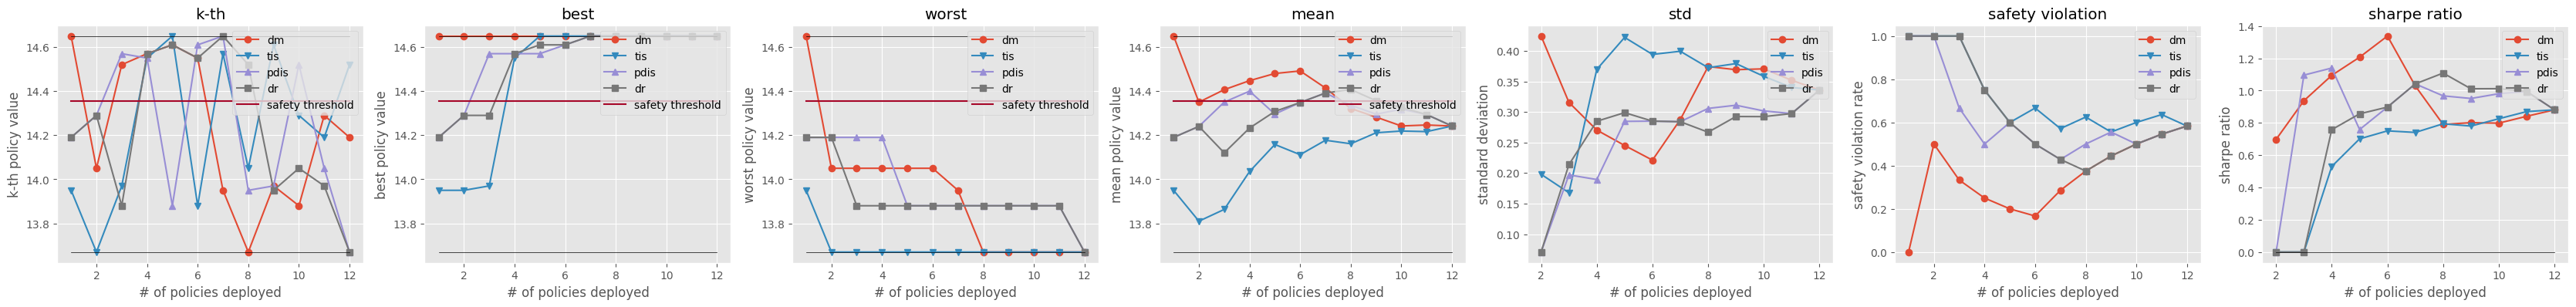

In [76]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    relative_safety_criteria=1.0,
    legend=True,
)

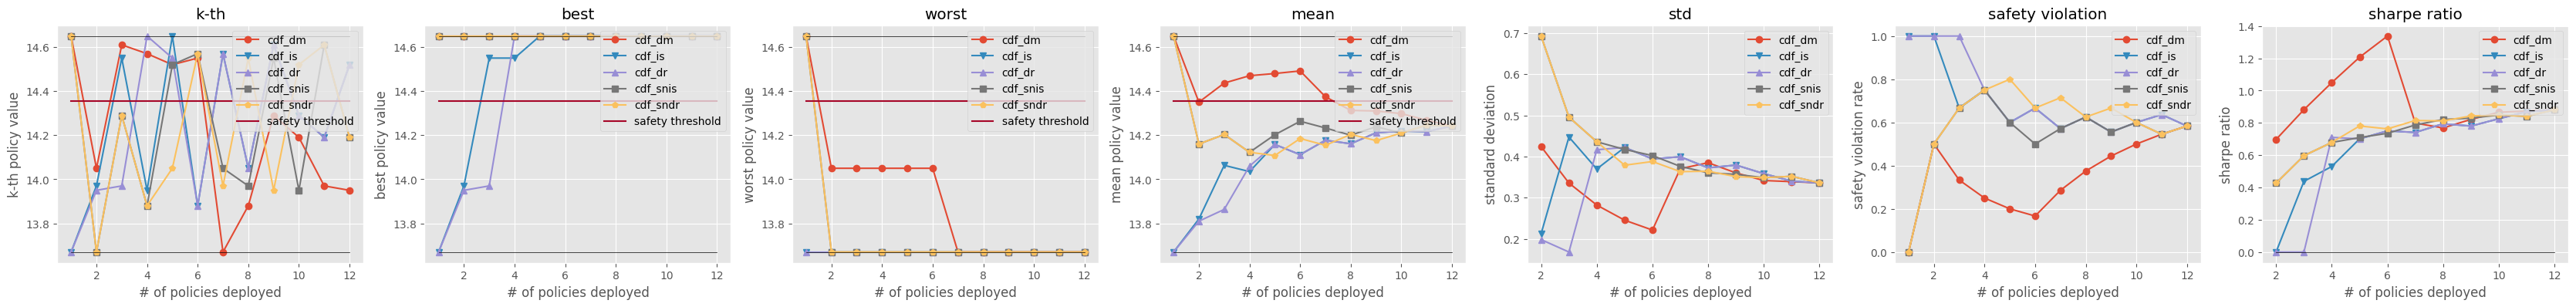

In [77]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    relative_safety_criteria=1.0,
    legend=True,
)

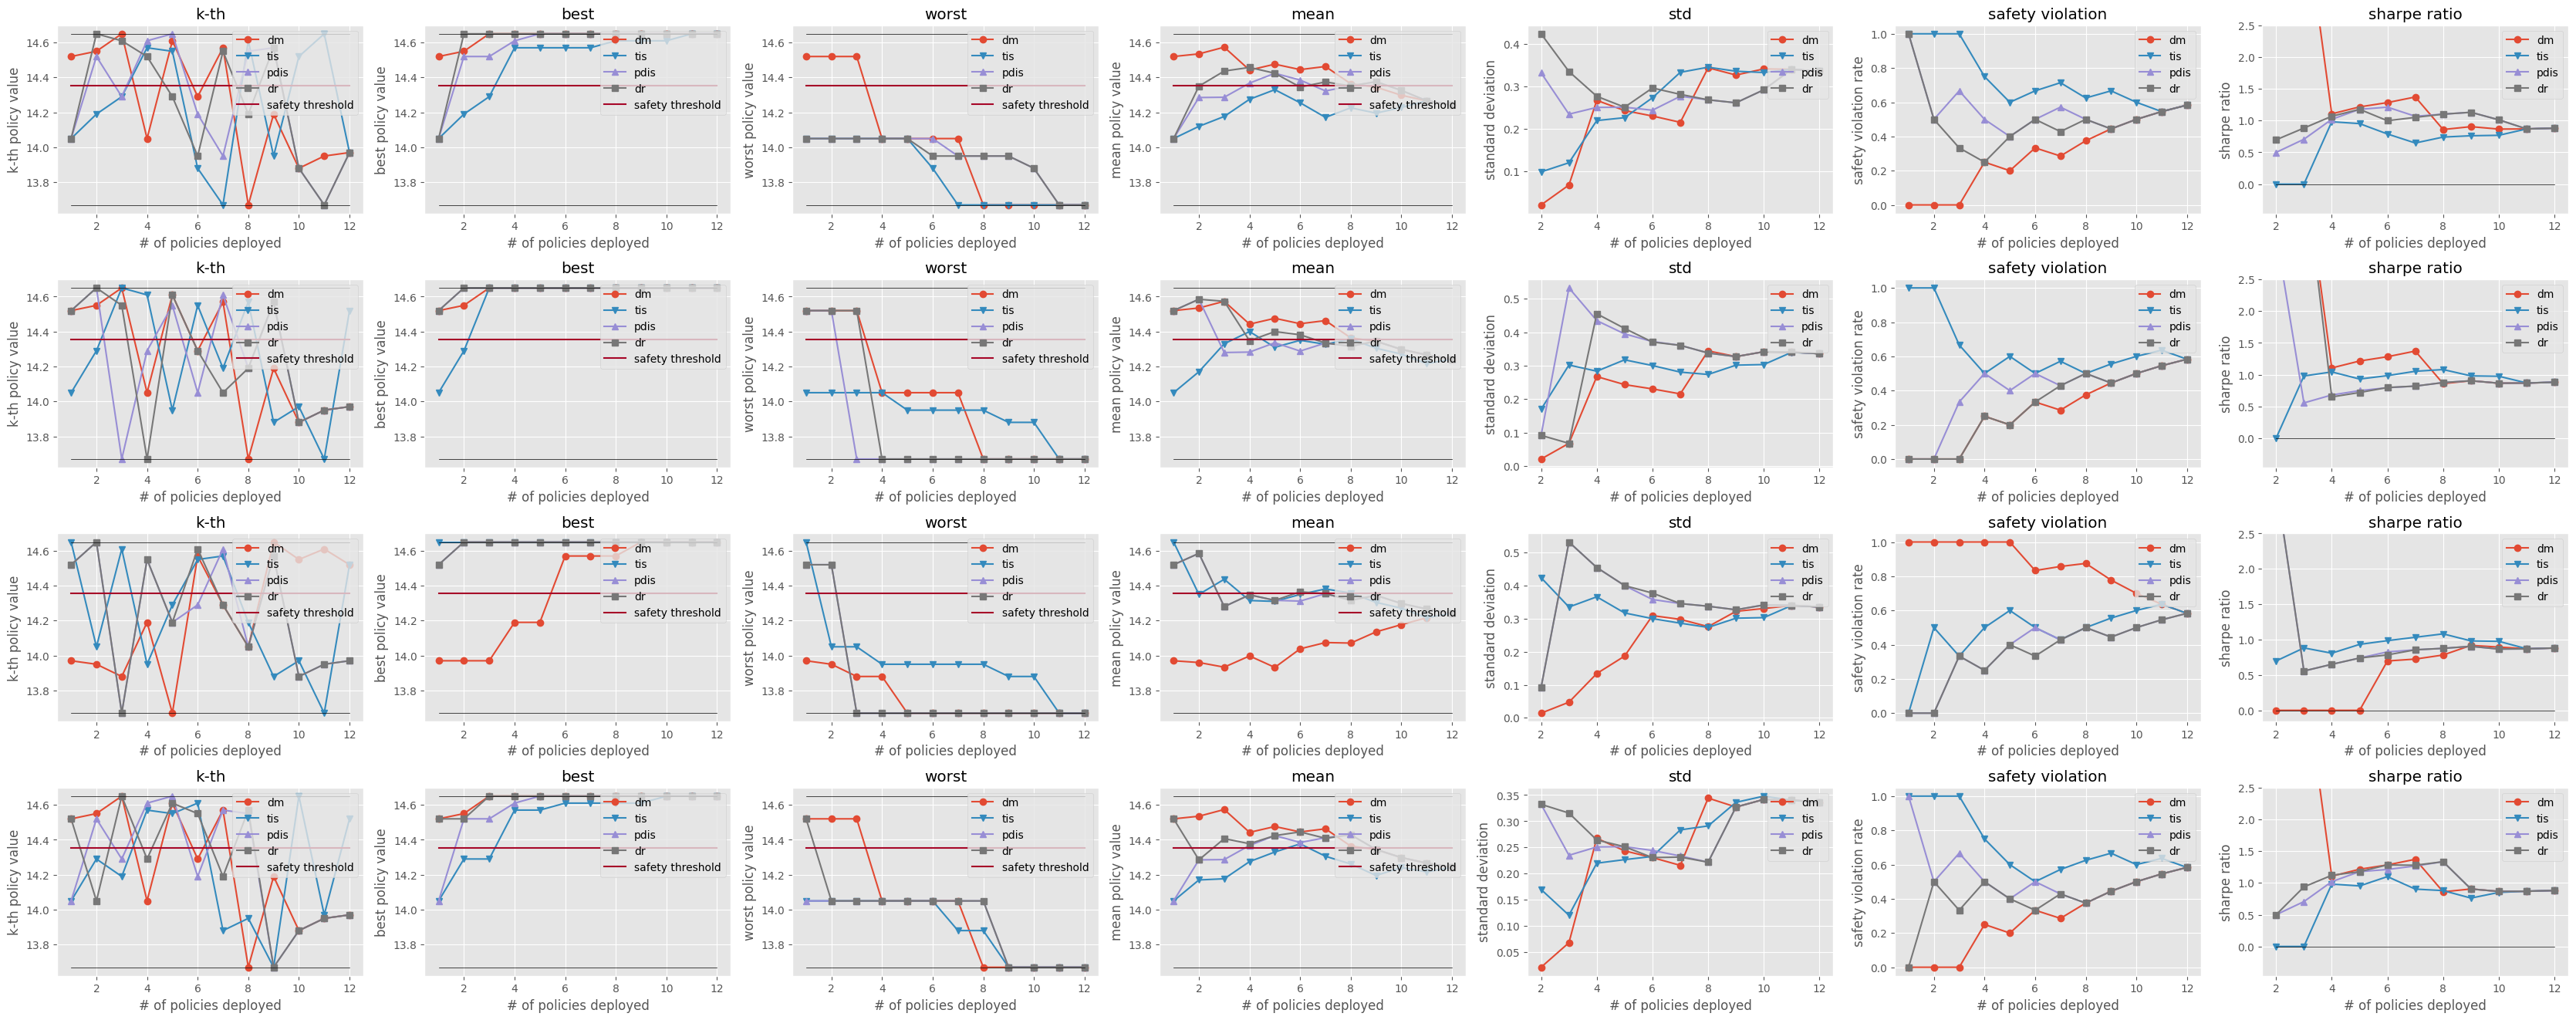

In [88]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    ymax_sharpe_ratio=2.5,
    relative_safety_criteria=1.0,
    legend=True,
    random_state=12345,
)

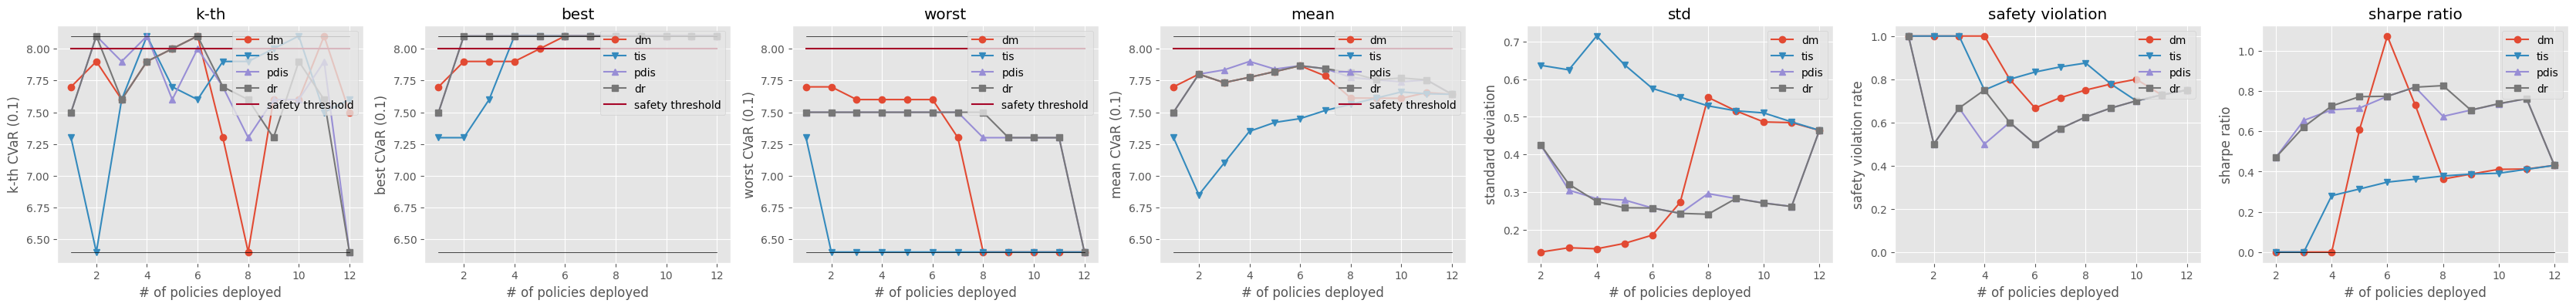

In [79]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
)

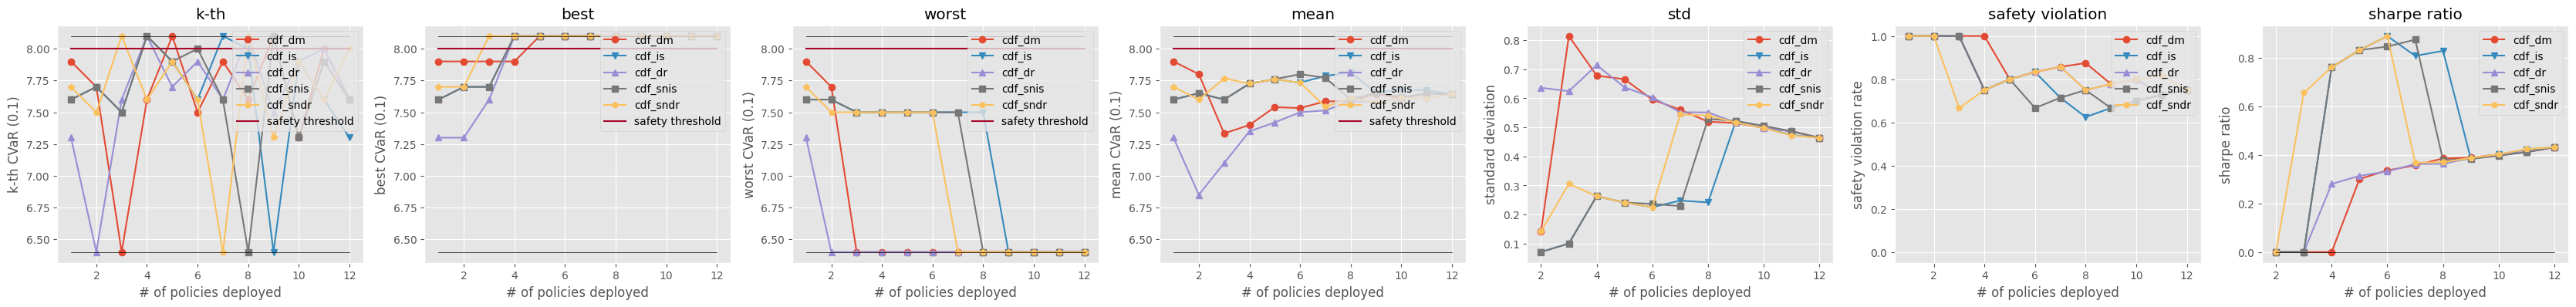

In [80]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
)

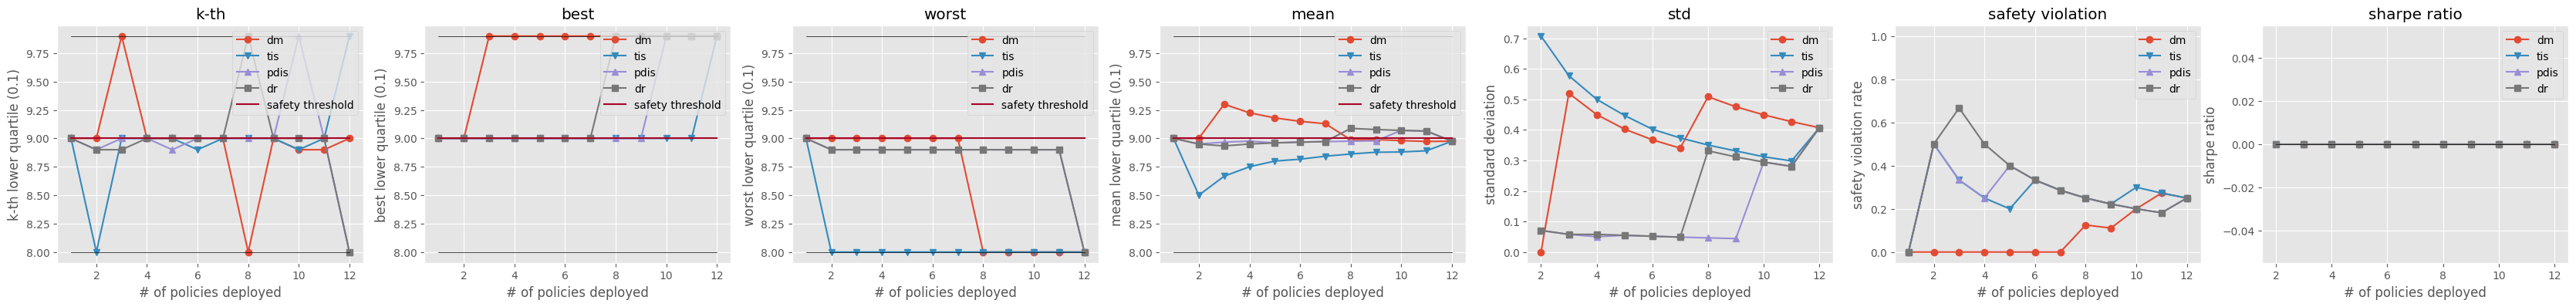

In [81]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
)

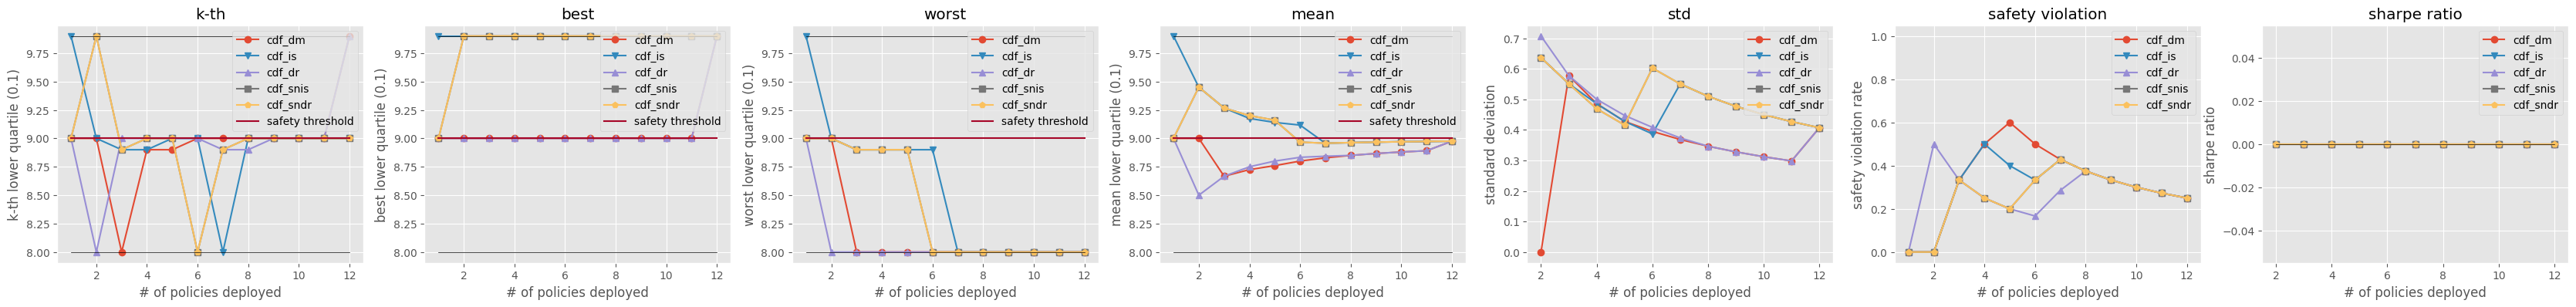

In [82]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
)

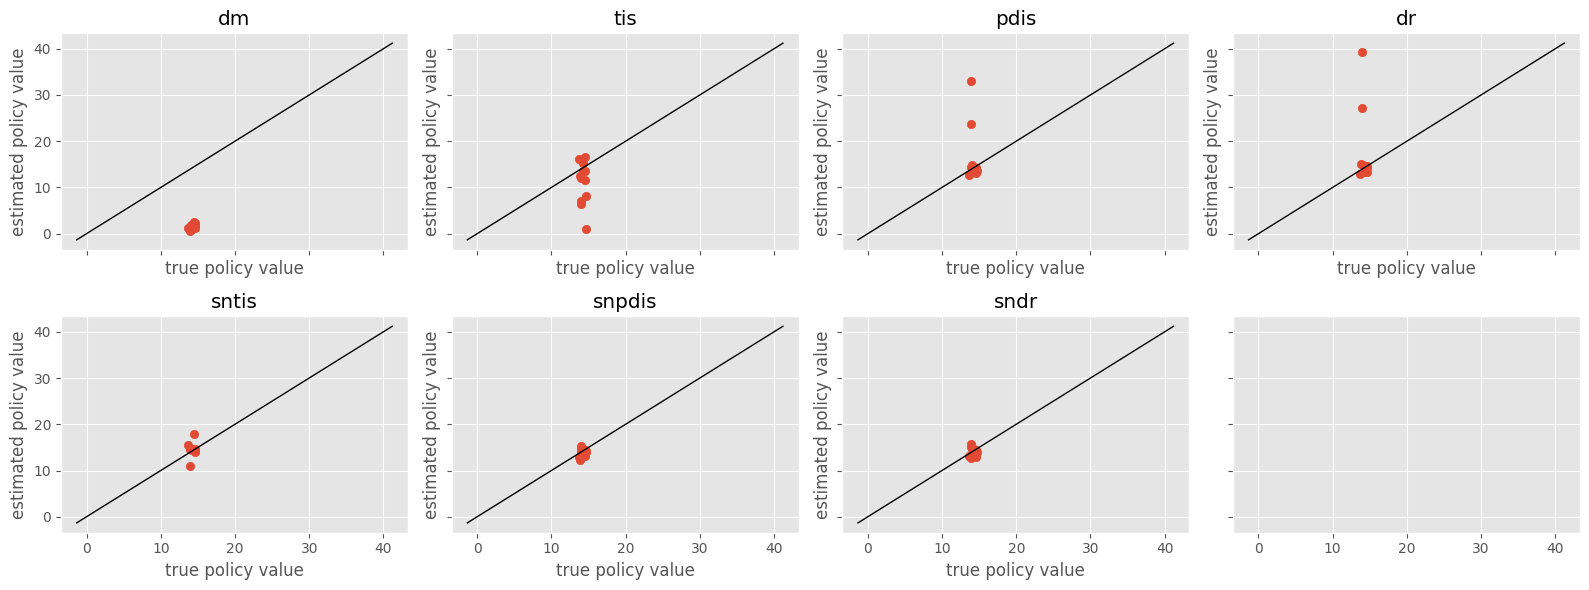

In [83]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

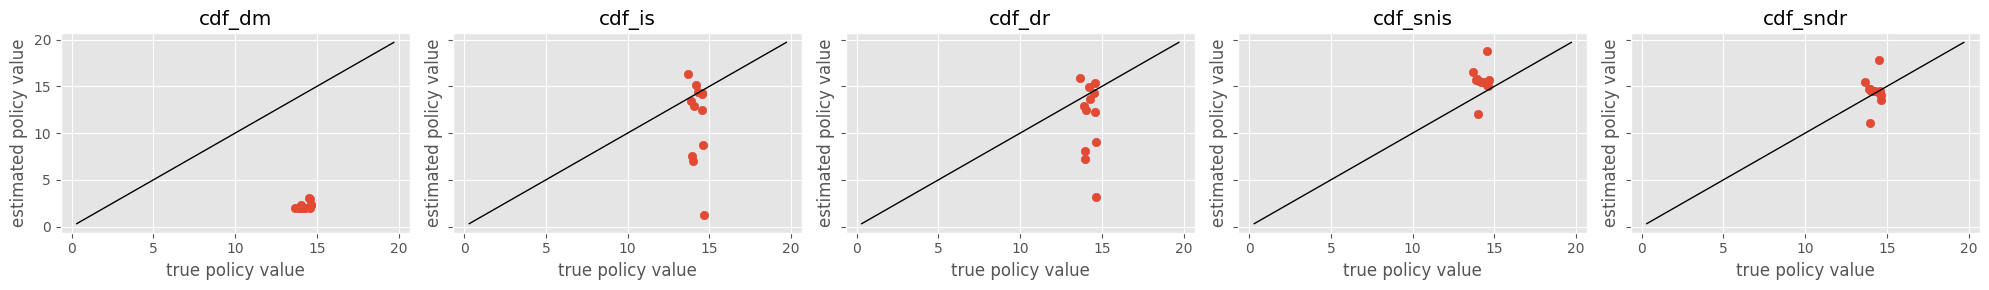

In [84]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

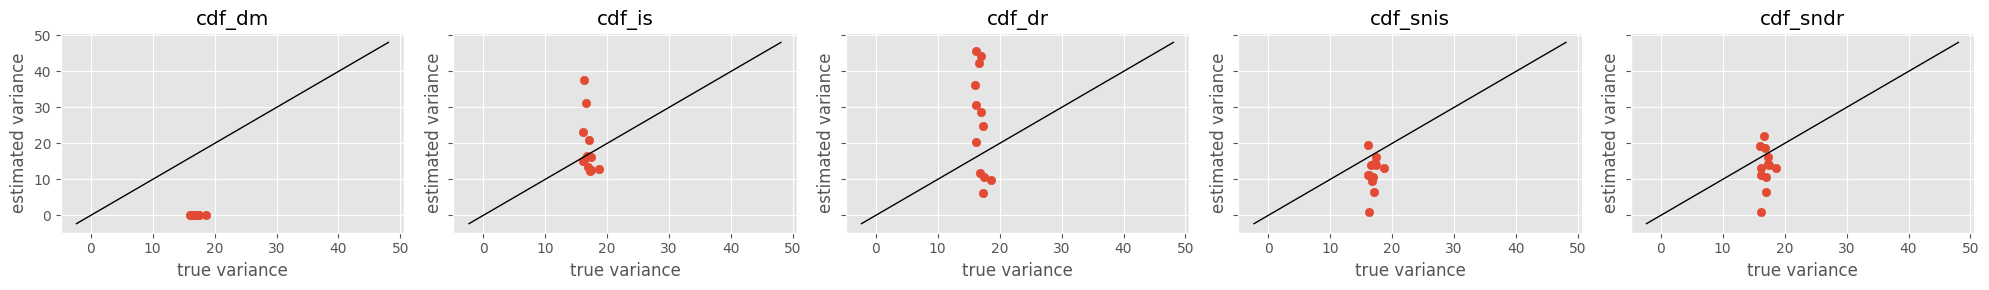

In [85]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

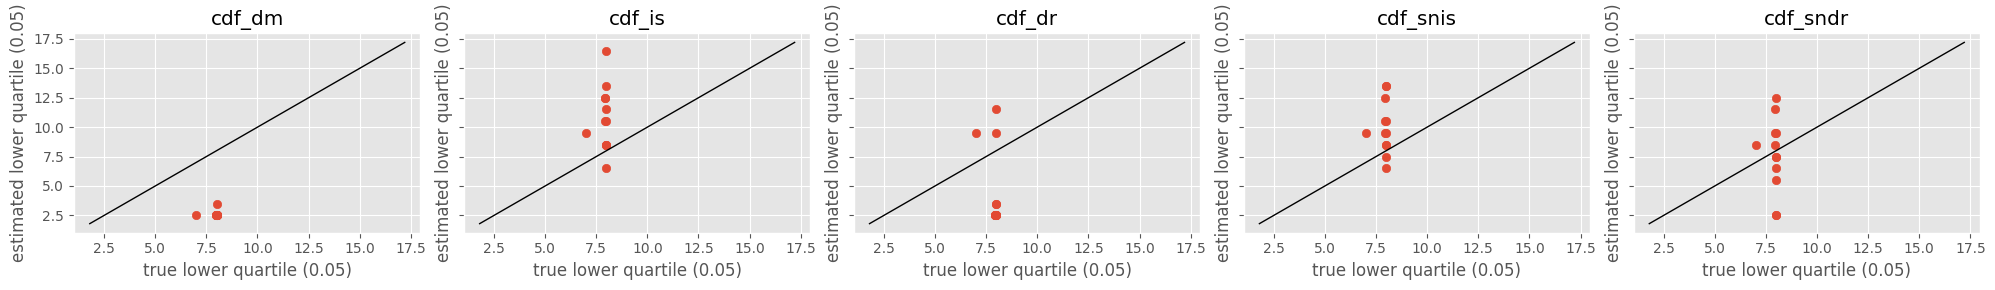

In [86]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

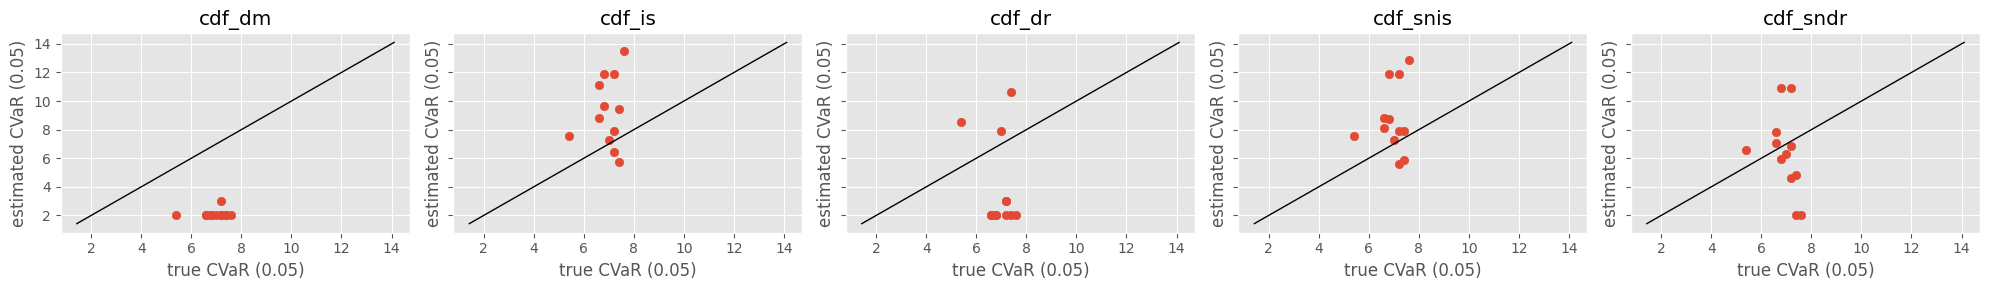

In [87]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

To see how to conduct OPE/OPS with multiple datasets, please refer to [examples/quickstart/rtb/rtb_synthetic_discrete_multiple_datasets.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_discrete_multiple_datasets.ipynb).

For the examples in the continuous action space, please refer to [examples/quickstart/rtb/rtb_synthetic_continuous_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_continuous_advanced.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.